## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


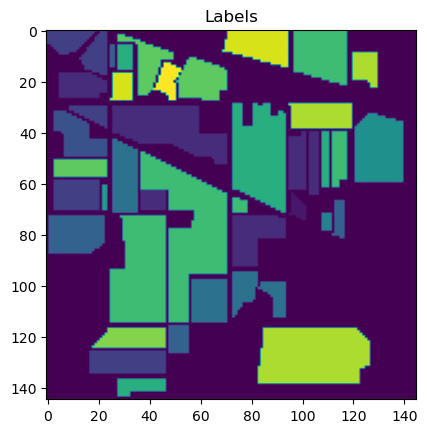

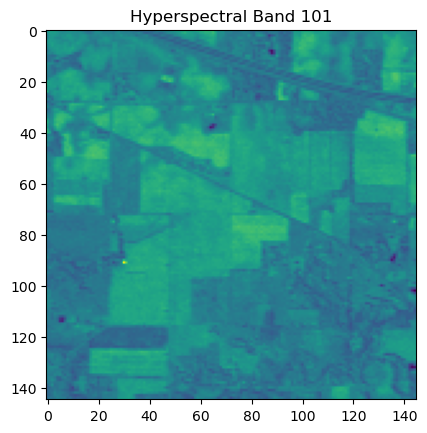

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class '7'
Se


All datasets saved to the 'indices' folder.
(80, 5, 5, 200)
(80, 5, 5, 200)
(10089, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 80
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0788, PSNR: 10.8127


Epoch [1/50] Training Loss: 0.0643, PSNR: 11.4867
	[Val]   Batch [1/33] Loss: 0.0495, PSNR: 12.7202
	[Val]   Batch [10/33] Loss: 0.0489, PSNR: 12.3748
	[Val]   Batch [20/33] Loss: 0.0485, PSNR: 11.9715
	[Val]   Batch [30/33] Loss: 0.0470, PSNR: 12.3531
Epoch [1/50] Validation Loss: 0.0491, PSNR: 12.5421

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0497, PSNR: 12.4965


Epoch [2/50] Training Loss: 0.0389, PSNR: 13.6697
	[Val]   Batch [1/33] Loss: 0.0284, PSNR: 15.1283
	[Val]   Batch [10/33] Loss: 0.0279, PSNR: 14.8027
	[Val]   Batch [20/33] Loss: 0.0277, PSNR: 14.4051
	[Val]   Batch [30/33] Loss: 0.0269, PSNR: 14.7709
Epoch [2/50] Validation Loss: 0.0283, PSNR: 14.9370

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0289, PSNR: 14.5289


Epoch [3/50] Training Loss: 0.0226, PSNR: 16.0260
	[Val]   Batch [1/33] Loss: 0.0168, PSNR: 17.4061
	[Val]   Batch [10/33] Loss: 0.0164, PSNR: 17.1169
	[Val]   Batch [20/33] Loss: 0.0161, PSNR: 16.7589
	[Val]   Batch [30/33] Loss: 0.0156, PSNR: 17.1497
Epoch [3/50] Validation Loss: 0.0168, PSNR: 17.2140

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0167, PSNR: 17.1352


Epoch [4/50] Training Loss: 0.0138, PSNR: 18.1879
	[Val]   Batch [1/33] Loss: 0.0110, PSNR: 19.2569
	[Val]   Batch [10/33] Loss: 0.0105, PSNR: 19.0377
	[Val]   Batch [20/33] Loss: 0.0103, PSNR: 18.7153
	[Val]   Batch [30/33] Loss: 0.0100, PSNR: 19.0943
Epoch [4/50] Validation Loss: 0.0109, PSNR: 19.0703

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0113, PSNR: 19.2629


Epoch [5/50] Training Loss: 0.0092, PSNR: 19.9237
	[Val]   Batch [1/33] Loss: 0.0079, PSNR: 20.6886
	[Val]   Batch [10/33] Loss: 0.0074, PSNR: 20.5564
	[Val]   Batch [20/33] Loss: 0.0072, PSNR: 20.2697
	[Val]   Batch [30/33] Loss: 0.0069, PSNR: 20.6582
Epoch [5/50] Validation Loss: 0.0078, PSNR: 20.5260

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0081, PSNR: 20.6971


Epoch [6/50] Training Loss: 0.0068, PSNR: 21.2682
	[Val]   Batch [1/33] Loss: 0.0059, PSNR: 21.9452
	[Val]   Batch [10/33] Loss: 0.0054, PSNR: 21.9095
	[Val]   Batch [20/33] Loss: 0.0052, PSNR: 21.6681
	[Val]   Batch [30/33] Loss: 0.0050, PSNR: 22.0491
Epoch [6/50] Validation Loss: 0.0059, PSNR: 21.8026

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0068, PSNR: 21.6628


Epoch [7/50] Training Loss: 0.0053, PSNR: 22.3485
	[Val]   Batch [1/33] Loss: 0.0048, PSNR: 22.8223
	[Val]   Batch [10/33] Loss: 0.0044, PSNR: 22.8642
	[Val]   Batch [20/33] Loss: 0.0041, PSNR: 22.6633
	[Val]   Batch [30/33] Loss: 0.0040, PSNR: 23.0722
Epoch [7/50] Validation Loss: 0.0048, PSNR: 22.6985

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0053, PSNR: 22.3724


Epoch [8/50] Training Loss: 0.0043, PSNR: 23.1686
	[Val]   Batch [1/33] Loss: 0.0040, PSNR: 23.6580
	[Val]   Batch [10/33] Loss: 0.0035, PSNR: 23.8031
	[Val]   Batch [20/33] Loss: 0.0033, PSNR: 23.6394
	[Val]   Batch [30/33] Loss: 0.0032, PSNR: 24.0794
Epoch [8/50] Validation Loss: 0.0039, PSNR: 23.5798

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0036, PSNR: 23.7882


Epoch [9/50] Training Loss: 0.0037, PSNR: 23.9424
	[Val]   Batch [1/33] Loss: 0.0035, PSNR: 24.2389
	[Val]   Batch [10/33] Loss: 0.0030, PSNR: 24.4658
	[Val]   Batch [20/33] Loss: 0.0028, PSNR: 24.3278
	[Val]   Batch [30/33] Loss: 0.0027, PSNR: 24.8062
Epoch [9/50] Validation Loss: 0.0034, PSNR: 24.2047

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0030, PSNR: 25.0159


Epoch [10/50] Training Loss: 0.0031, PSNR: 24.6001
	[Val]   Batch [1/33] Loss: 0.0030, PSNR: 24.9621
	[Val]   Batch [10/33] Loss: 0.0025, PSNR: 25.2831
	[Val]   Batch [20/33] Loss: 0.0023, PSNR: 25.1916
	[Val]   Batch [30/33] Loss: 0.0022, PSNR: 25.7074
Epoch [10/50] Validation Loss: 0.0028, PSNR: 24.9735

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 25.9028


Epoch [11/50] Training Loss: 0.0028, PSNR: 25.1459
	[Val]   Batch [1/33] Loss: 0.0027, PSNR: 25.3688
	[Val]   Batch [10/33] Loss: 0.0023, PSNR: 25.7192
	[Val]   Batch [20/33] Loss: 0.0021, PSNR: 25.6403
	[Val]   Batch [30/33] Loss: 0.0019, PSNR: 26.2000
Epoch [11/50] Validation Loss: 0.0026, PSNR: 25.3984

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0029, PSNR: 25.0527


Epoch [12/50] Training Loss: 0.0025, PSNR: 25.6136
	[Val]   Batch [1/33] Loss: 0.0024, PSNR: 25.8363
	[Val]   Batch [10/33] Loss: 0.0020, PSNR: 26.2172
	[Val]   Batch [20/33] Loss: 0.0019, PSNR: 26.1551
	[Val]   Batch [30/33] Loss: 0.0017, PSNR: 26.7448
Epoch [12/50] Validation Loss: 0.0023, PSNR: 25.8841

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0026, PSNR: 25.8763


Epoch [13/50] Training Loss: 0.0023, PSNR: 25.9976
	[Val]   Batch [1/33] Loss: 0.0022, PSNR: 26.3379
	[Val]   Batch [10/33] Loss: 0.0018, PSNR: 26.7326
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.6866
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.2943
Epoch [13/50] Validation Loss: 0.0021, PSNR: 26.3873

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0019, PSNR: 27.3030


Epoch [14/50] Training Loss: 0.0021, PSNR: 26.3624
	[Val]   Batch [1/33] Loss: 0.0020, PSNR: 26.6766
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 27.0481
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 27.0052
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.6275
Epoch [14/50] Validation Loss: 0.0019, PSNR: 26.7101

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.3321


Epoch [15/50] Training Loss: 0.0019, PSNR: 26.7278
	[Val]   Batch [1/33] Loss: 0.0017, PSNR: 27.3118
	[Val]   Batch [10/33] Loss: 0.0015, PSNR: 27.6390
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.5787
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.2513
Epoch [15/50] Validation Loss: 0.0017, PSNR: 27.3018

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0019, PSNR: 26.8982


Epoch [16/50] Training Loss: 0.0018, PSNR: 27.0792
	[Val]   Batch [1/33] Loss: 0.0016, PSNR: 27.7136
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.0155
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 27.9687
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.6453
Epoch [16/50] Validation Loss: 0.0015, PSNR: 27.6864

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0017, PSNR: 27.6148


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.4073
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 28.0422
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.3037
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.2656
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 28.9990
Epoch [17/50] Validation Loss: 0.0014, PSNR: 28.0183

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.2355


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.7093
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.3591
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.5875
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.5769
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.3293
Epoch [18/50] Validation Loss: 0.0013, PSNR: 28.3362

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0028, PSNR: 25.5919


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.9569
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.4996
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.7268
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.7688
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.4989
Epoch [19/50] Validation Loss: 0.0013, PSNR: 28.5032

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 25.6608


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.2615
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.1363
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.3336
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.4048
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.1104
Epoch [20/50] Validation Loss: 0.0011, PSNR: 29.1135

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0017, PSNR: 27.4789


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.4921
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.4462
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.6381
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.7690
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.4864
Epoch [21/50] Validation Loss: 0.0010, PSNR: 29.4425

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.2729


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.7284
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.8091
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 29.9762
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.1454
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.8650
Epoch [22/50] Validation Loss: 0.0009, PSNR: 29.8123

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.6052


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.9834
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 29.9681
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.1181
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.2981
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.0453
Epoch [23/50] Validation Loss: 0.0009, PSNR: 29.9742

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 30.1466


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.1325
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1109
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.2395
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.4619
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.2269
Epoch [24/50] Validation Loss: 0.0009, PSNR: 30.1398

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.7567


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.2992
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.2728
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4043
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6145
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.4010
Epoch [25/50] Validation Loss: 0.0008, PSNR: 30.2959
Early stopping triggered at epoch 25. No improvement for 3 epochs.


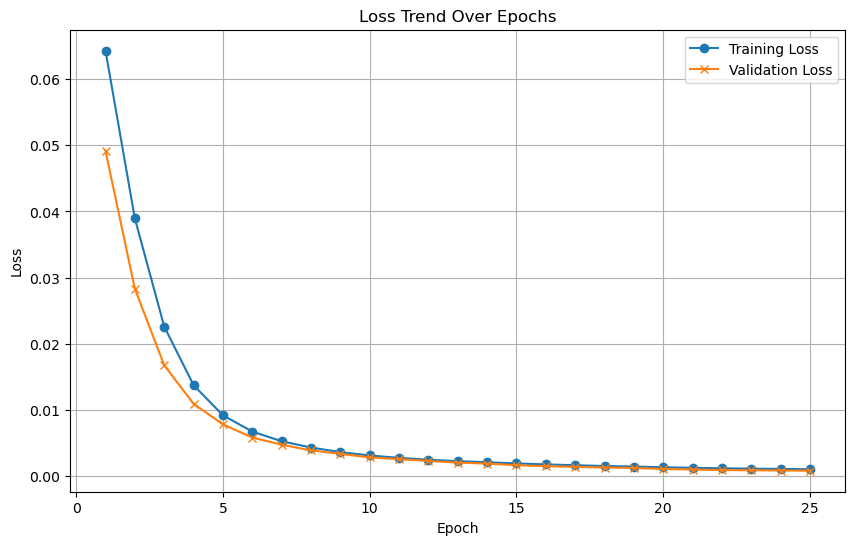

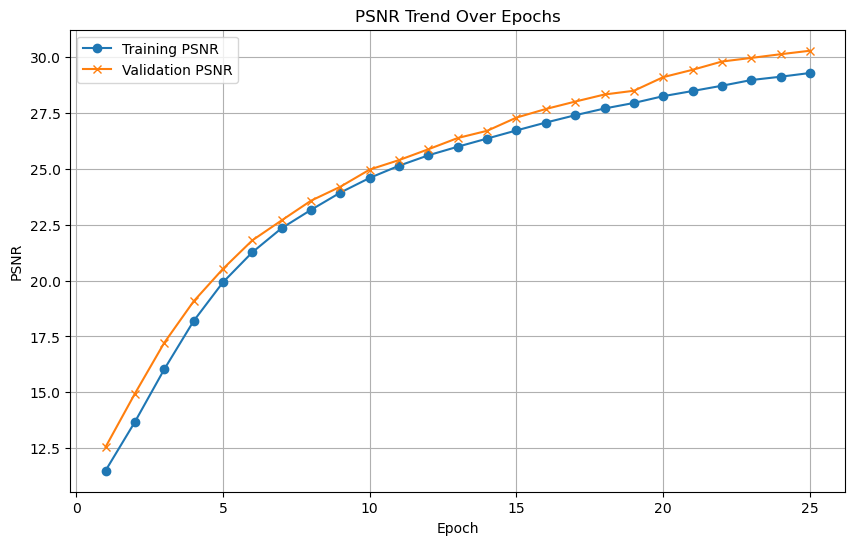

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/40 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7676
    Validation Batch [1/1], Loss: 2.7772
Validation Loss: 2.7772, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7772. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7313
    Validation Batch [1/1], Loss: 2.7772
Validation Loss: 2.7772, Validation Accuracy: 6.25%
Validation loss improved from 2.7772 to 2.7772. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.6994
    Validation Batch [1/1], Loss: 2.7771
Validation Loss: 2.7771, Validation Accuracy: 6.25%
Validation loss improved from 2.7772 to 2.7771. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7024
    Validation Batch [1/1], Loss: 2.7771
Validation Loss: 2.7771, Validation Accuracy: 6.25%
Validation loss improved from 2.7771 to 2.7771. Saving model...

LOG: Epoch [5/1000] - 

Epoch [8/1000] completed, Average Training Loss: 2.6623
    Validation Batch [1/1], Loss: 2.7769
Validation Loss: 2.7769, Validation Accuracy: 6.25%
Validation loss improved from 2.7769 to 2.7769. Saving model...

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.6328
    Validation Batch [1/1], Loss: 2.7768
Validation Loss: 2.7768, Validation Accuracy: 6.25%
Validation loss improved from 2.7769 to 2.7768. Saving model...

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6388
    Validation Batch [1/1], Loss: 2.7767
Validation Loss: 2.7767, Validation Accuracy: 6.25%
Validation loss improved from 2.7768 to 2.7767. Saving model...

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6072
    Validation Batch [1/1], Loss: 2.7766
Validation Loss: 2.7766, Validation Accuracy: 6.25%
Validation loss improved from 2.7767 to 2.7766. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000]

    Validation Batch [1/1], Loss: 2.7745
Validation Loss: 2.7745, Validation Accuracy: 6.25%
Validation loss improved from 2.7749 to 2.7745. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4906
    Validation Batch [1/1], Loss: 2.7740
Validation Loss: 2.7740, Validation Accuracy: 6.25%
Validation loss improved from 2.7745 to 2.7740. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.5043
    Validation Batch [1/1], Loss: 2.7735
Validation Loss: 2.7735, Validation Accuracy: 6.25%
Validation loss improved from 2.7740 to 2.7735. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.4956
    Validation Batch [1/1], Loss: 2.7730
Validation Loss: 2.7730, Validation Accuracy: 6.25%
Validation loss improved from 2.7735 to 2.7730. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.4821
    Validati

Epoch [37/1000] completed, Average Training Loss: 2.3642
    Validation Batch [1/1], Loss: 2.7475
Validation Loss: 2.7475, Validation Accuracy: 11.25%
Validation loss improved from 2.7512 to 2.7475. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 2.3503
    Validation Batch [1/1], Loss: 2.7428
Validation Loss: 2.7428, Validation Accuracy: 11.25%
Validation loss improved from 2.7475 to 2.7428. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.3875
    Validation Batch [1/1], Loss: 2.7363
Validation Loss: 2.7363, Validation Accuracy: 15.00%
Validation loss improved from 2.7428 to 2.7363. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.3310
    Validation Batch [1/1], Loss: 2.7305
Validation Loss: 2.7305, Validation Accuracy: 15.00%
Validation loss improved from 2.7363 to 2.7305. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [4

    Validation Batch [1/1], Loss: 2.6235
Validation Loss: 2.6235, Validation Accuracy: 31.25%
Validation loss improved from 2.6333 to 2.6235. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.2146
    Validation Batch [1/1], Loss: 2.6041
Validation Loss: 2.6041, Validation Accuracy: 27.50%
Validation loss improved from 2.6235 to 2.6041. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.2112
    Validation Batch [1/1], Loss: 2.5820
Validation Loss: 2.5820, Validation Accuracy: 27.50%
Validation loss improved from 2.6041 to 2.5820. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 2.2073
    Validation Batch [1/1], Loss: 2.5805
Validation Loss: 2.5805, Validation Accuracy: 28.75%
Validation loss improved from 2.5820 to 2.5805. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 2.2246
    Vali

    Validation Batch [1/1], Loss: 2.4867
Validation Loss: 2.4867, Validation Accuracy: 25.00%
Validation loss improved from 2.5030 to 2.4867. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 2.1544
    Validation Batch [1/1], Loss: 2.4875
Validation Loss: 2.4875, Validation Accuracy: 26.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 2.1053
    Validation Batch [1/1], Loss: 2.4880
Validation Loss: 2.4880, Validation Accuracy: 27.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 2.1478
    Validation Batch [1/1], Loss: 2.4899
Validation Loss: 2.4899, Validation Accuracy: 27.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 2.0897
    Validation Batch [1/1], Loss: 2.4710
Validation L

    Validation Batch [1/1], Loss: 2.3957
Validation Loss: 2.3957, Validation Accuracy: 27.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.9930
    Validation Batch [1/1], Loss: 2.3968
Validation Loss: 2.3968, Validation Accuracy: 28.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.9706
    Validation Batch [1/1], Loss: 2.3698
Validation Loss: 2.3698, Validation Accuracy: 30.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.9522
    Validation Batch [1/1], Loss: 2.3272
Validation Loss: 2.3272, Validation Accuracy: 31.25%
Validation loss improved from 2.3625 to 2.3272. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.9148
    Validation Batch [1/1], Loss: 2.3137
Validation L

Epoch [94/1000] completed, Average Training Loss: 1.9061
    Validation Batch [1/1], Loss: 2.2917
Validation Loss: 2.2917, Validation Accuracy: 36.25%
Validation loss improved from 2.2994 to 2.2917. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.8529
    Validation Batch [1/1], Loss: 2.2902
Validation Loss: 2.2902, Validation Accuracy: 38.75%
Validation loss improved from 2.2917 to 2.2902. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.9053
    Validation Batch [1/1], Loss: 2.2850
Validation Loss: 2.2850, Validation Accuracy: 35.00%
Validation loss improved from 2.2902 to 2.2850. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.8782
    Validation Batch [1/1], Loss: 2.2753
Validation Loss: 2.2753, Validation Accuracy: 32.50%
Validation loss improved from 2.2850 to 2.2753. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [9

    Validation Batch [1/1], Loss: 2.1851
Validation Loss: 2.1851, Validation Accuracy: 33.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.7441
    Validation Batch [1/1], Loss: 2.1732
Validation Loss: 2.1732, Validation Accuracy: 40.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.7118
    Validation Batch [1/1], Loss: 2.1679
Validation Loss: 2.1679, Validation Accuracy: 41.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 1.7020
    Validation Batch [1/1], Loss: 2.1752
Validation Loss: 2.1752, Validation Accuracy: 38.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 1.6915
    Validation Batch [1/1], Loss: 2.1803
Validation Loss: 2.

    Validation Batch [1/1], Loss: 2.1570
Validation Loss: 2.1570, Validation Accuracy: 33.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.6396
    Validation Batch [1/1], Loss: 2.1358
Validation Loss: 2.1358, Validation Accuracy: 38.75%
Validation loss improved from 2.1529 to 2.1358. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 1.6618
    Validation Batch [1/1], Loss: 2.1262
Validation Loss: 2.1262, Validation Accuracy: 43.75%
Validation loss improved from 2.1358 to 2.1262. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 1.6533
    Validation Batch [1/1], Loss: 2.1390
Validation Loss: 2.1390, Validation Accuracy: 45.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.6460
    Validation Batch [1/1], Lo

Epoch [146/1000] completed, Average Training Loss: 1.4897
    Validation Batch [1/1], Loss: 2.0693
Validation Loss: 2.0693, Validation Accuracy: 45.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 1.5167
    Validation Batch [1/1], Loss: 2.0669
Validation Loss: 2.0669, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.4956
    Validation Batch [1/1], Loss: 2.0779
Validation Loss: 2.0779, Validation Accuracy: 42.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.4595
    Validation Batch [1/1], Loss: 2.0430
Validation Loss: 2.0430, Validation Accuracy: 43.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 1.4453
  

Epoch [154/1000] completed, Average Training Loss: 1.4103
    Validation Batch [1/1], Loss: 2.0026
Validation Loss: 2.0026, Validation Accuracy: 46.25%
Validation loss improved from 2.0165 to 2.0026. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.4142
    Validation Batch [1/1], Loss: 2.0016
Validation Loss: 2.0016, Validation Accuracy: 43.75%
Validation loss improved from 2.0026 to 2.0016. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.4557
    Validation Batch [1/1], Loss: 2.0220
Validation Loss: 2.0220, Validation Accuracy: 38.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 1.3640
    Validation Batch [1/1], Loss: 2.0137
Validation Loss: 2.0137, Validation Accuracy: 42.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Av

Epoch [176/1000] completed, Average Training Loss: 1.2448
    Validation Batch [1/1], Loss: 1.9465
Validation Loss: 1.9465, Validation Accuracy: 56.25%
Validation loss improved from 1.9586 to 1.9465. Saving model...

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 1.2792
    Validation Batch [1/1], Loss: 1.9385
Validation Loss: 1.9385, Validation Accuracy: 50.00%
Validation loss improved from 1.9465 to 1.9385. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 1.1962
    Validation Batch [1/1], Loss: 1.9553
Validation Loss: 1.9553, Validation Accuracy: 45.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.2941
    Validation Batch [1/1], Loss: 1.9703
Validation Loss: 1.9703, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Av

Epoch [185/1000] completed, Average Training Loss: 1.1558
    Validation Batch [1/1], Loss: 1.9439
Validation Loss: 1.9439, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 1.1729
    Validation Batch [1/1], Loss: 1.9367
Validation Loss: 1.9367, Validation Accuracy: 55.00%
Validation loss improved from 1.9385 to 1.9367. Saving model...

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 1.1802
    Validation Batch [1/1], Loss: 1.9515
Validation Loss: 1.9515, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 1.1219
    Validation Batch [1/1], Loss: 1.9668
Validation Loss: 1.9668, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training 

Epoch [206/1000] completed, Average Training Loss: 1.0482
    Validation Batch [1/1], Loss: 1.9266
Validation Loss: 1.9266, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 1.0163
    Validation Batch [1/1], Loss: 1.9024
Validation Loss: 1.9024, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 1.0200
    Validation Batch [1/1], Loss: 1.9336
Validation Loss: 1.9336, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.9747
    Validation Batch [1/1], Loss: 1.9304
Validation Loss: 1.9304, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 1.0188
  

Epoch [214/1000] completed, Average Training Loss: 0.9375
    Validation Batch [1/1], Loss: 1.8765
Validation Loss: 1.8765, Validation Accuracy: 55.00%
Validation loss improved from 1.8825 to 1.8765. Saving model...

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.9389
    Validation Batch [1/1], Loss: 1.8692
Validation Loss: 1.8692, Validation Accuracy: 51.25%
Validation loss improved from 1.8765 to 1.8692. Saving model...

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.9047
    Validation Batch [1/1], Loss: 1.8640
Validation Loss: 1.8640, Validation Accuracy: 53.75%
Validation loss improved from 1.8692 to 1.8640. Saving model...

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.9634
    Validation Batch [1/1], Loss: 1.8278
Validation Loss: 1.8278, Validation Accuracy: 53.75%
Validation loss improved from 1.8640 to 1.8278. Saving model...

LOG: Epoch [218/1000] - Training


Epoch [236/1000] completed, Average Training Loss: 0.7402
    Validation Batch [1/1], Loss: 1.8056
Validation Loss: 1.8056, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.7735
    Validation Batch [1/1], Loss: 1.8096
Validation Loss: 1.8096, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.7969
    Validation Batch [1/1], Loss: 1.8260
Validation Loss: 1.8260, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.8384
    Validation Batch [1/1], Loss: 1.8468
Validation Loss: 1.8468, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.7756
  

Epoch [243/1000] completed, Average Training Loss: 0.7838
    Validation Batch [1/1], Loss: 1.8797
Validation Loss: 1.8797, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.6511
    Validation Batch [1/1], Loss: 1.8643
Validation Loss: 1.8643, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.7220
    Validation Batch [1/1], Loss: 1.8251
Validation Loss: 1.8251, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.6996
    Validation Batch [1/1], Loss: 1.8291
Validation Loss: 1.8291, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.7648


Validation Loss: 1.8291, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.5870
    Validation Batch [1/1], Loss: 1.8263
Validation Loss: 1.8263, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.6286
    Validation Batch [1/1], Loss: 1.8348
Validation Loss: 1.8348, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.6305
    Validation Batch [1/1], Loss: 1.8068
Validation Loss: 1.8068, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.5861
    Validation Batch [1/1], Loss: 1.7838
Validation Loss: 1.7838, Validation Accuracy: 60.00%
Validat

    Validation Batch [1/1], Loss: 1.7983
Validation Loss: 1.7983, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.5588
    Validation Batch [1/1], Loss: 1.7818
Validation Loss: 1.7818, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.5695
    Validation Batch [1/1], Loss: 1.7673
Validation Loss: 1.7673, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.5708
    Validation Batch [1/1], Loss: 1.7793
Validation Loss: 1.7793, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.5617
    Validation Batch [1/1], Loss: 1.7921
Validation Loss

Epoch [295/1000] completed, Average Training Loss: 0.4875
    Validation Batch [1/1], Loss: 1.7569
Validation Loss: 1.7569, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.4719
    Validation Batch [1/1], Loss: 1.7517
Validation Loss: 1.7517, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.4547
    Validation Batch [1/1], Loss: 1.7673
Validation Loss: 1.7673, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.4813
    Validation Batch [1/1], Loss: 1.7695
Validation Loss: 1.7695, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.444

Epoch [304/1000] completed, Average Training Loss: 0.4235
    Validation Batch [1/1], Loss: 1.6847
Validation Loss: 1.6847, Validation Accuracy: 61.25%
Validation loss improved from 1.7092 to 1.6847. Saving model...

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.4212
    Validation Batch [1/1], Loss: 1.6982
Validation Loss: 1.6982, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.3749
    Validation Batch [1/1], Loss: 1.7017
Validation Loss: 1.7017, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.5086
    Validation Batch [1/1], Loss: 1.7501
Validation Loss: 1.7501, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training 

Epoch [326/1000] completed, Average Training Loss: 0.3577
    Validation Batch [1/1], Loss: 1.7569
Validation Loss: 1.7569, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.3299
    Validation Batch [1/1], Loss: 1.7480
Validation Loss: 1.7480, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.3267
    Validation Batch [1/1], Loss: 1.7317
Validation Loss: 1.7317, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.3349
    Validation Batch [1/1], Loss: 1.7767
Validation Loss: 1.7767, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.3886
  

Epoch [335/1000] completed, Average Training Loss: 0.3403
    Validation Batch [1/1], Loss: 1.8037
Validation Loss: 1.8037, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.3271
    Validation Batch [1/1], Loss: 1.7773
Validation Loss: 1.7773, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.3543
    Validation Batch [1/1], Loss: 1.7287
Validation Loss: 1.7287, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.3125
    Validation Batch [1/1], Loss: 1.7486
Validation Loss: 1.7486, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.348

Epoch [356/1000] completed, Average Training Loss: 0.2998
    Validation Batch [1/1], Loss: 1.6976
Validation Loss: 1.6976, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.2963
    Validation Batch [1/1], Loss: 1.7195
Validation Loss: 1.7195, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.2228
    Validation Batch [1/1], Loss: 1.7460
Validation Loss: 1.7460, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.2633
    Validation Batch [1/1], Loss: 1.7345
Validation Loss: 1.7345, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.231

    Validation Batch [1/1], Loss: 1.7130
Validation Loss: 1.7130, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.2299
    Validation Batch [1/1], Loss: 1.7314
Validation Loss: 1.7314, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.2562
    Validation Batch [1/1], Loss: 1.7251
Validation Loss: 1.7251, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.2540
    Validation Batch [1/1], Loss: 1.7257
Validation Loss: 1.7257, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.2386
    Validation Batch [1/1], Loss: 1.7428
Validation Loss

Epoch [384/1000] completed, Average Training Loss: 0.2177
    Validation Batch [1/1], Loss: 1.6889
Validation Loss: 1.6889, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.2401
    Validation Batch [1/1], Loss: 1.6785
Validation Loss: 1.6785, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.1972
    Validation Batch [1/1], Loss: 1.6918
Validation Loss: 1.6918, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.2135
    Validation Batch [1/1], Loss: 1.7257
Validation Loss: 1.7257, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.233

Epoch [393/1000] completed, Average Training Loss: 0.2124
    Validation Batch [1/1], Loss: 1.7343
Validation Loss: 1.7343, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.2389
    Validation Batch [1/1], Loss: 1.7356
Validation Loss: 1.7356, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.2226
    Validation Batch [1/1], Loss: 1.7879
Validation Loss: 1.7879, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.1878
    Validation Batch [1/1], Loss: 1.8151
Validation Loss: 1.8151, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.195

Epoch [412/1000] completed, Average Training Loss: 0.1668
    Validation Batch [1/1], Loss: 1.6815
Validation Loss: 1.6815, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.1892
    Validation Batch [1/1], Loss: 1.7000
Validation Loss: 1.7000, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.1910
    Validation Batch [1/1], Loss: 1.7020
Validation Loss: 1.7020, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.2061
    Validation Batch [1/1], Loss: 1.7634
Validation Loss: 1.7634, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.1856
  

Epoch [423/1000] completed, Average Training Loss: 0.1865
    Validation Batch [1/1], Loss: 1.7405
Validation Loss: 1.7405, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1686
    Validation Batch [1/1], Loss: 1.7583
Validation Loss: 1.7583, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1590
    Validation Batch [1/1], Loss: 1.7703
Validation Loss: 1.7703, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1418
    Validation Batch [1/1], Loss: 1.8371
Validation Loss: 1.8371, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.170

Epoch [441/1000] completed, Average Training Loss: 0.1338
    Validation Batch [1/1], Loss: 1.8400
Validation Loss: 1.8400, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.1510
    Validation Batch [1/1], Loss: 1.7809
Validation Loss: 1.7809, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.1742
    Validation Batch [1/1], Loss: 1.8016
Validation Loss: 1.8016, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.1522
    Validation Batch [1/1], Loss: 1.8154
Validation Loss: 1.8154, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.160

    Validation Batch [1/1], Loss: 1.7584
Validation Loss: 1.7584, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1158
    Validation Batch [1/1], Loss: 1.8392
Validation Loss: 1.8392, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.1511
    Validation Batch [1/1], Loss: 1.8204
Validation Loss: 1.8204, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.1339
    Validation Batch [1/1], Loss: 1.7657
Validation Loss: 1.7657, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.1502
    Validation Batch [1/1], Loss: 1.7564
Validation Loss

Epoch [470/1000] completed, Average Training Loss: 0.1649
    Validation Batch [1/1], Loss: 1.7984
Validation Loss: 1.7984, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.1326
    Validation Batch [1/1], Loss: 1.8037
Validation Loss: 1.8037, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.1363
    Validation Batch [1/1], Loss: 1.7911
Validation Loss: 1.7911, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.0987
    Validation Batch [1/1], Loss: 1.7575
Validation Loss: 1.7575, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.103

Epoch [485/1000] completed, Average Training Loss: 0.1403
    Validation Batch [1/1], Loss: 1.7425
Validation Loss: 1.7425, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.1080
    Validation Batch [1/1], Loss: 1.7514
Validation Loss: 1.7514, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.1325
    Validation Batch [1/1], Loss: 1.7457
Validation Loss: 1.7457, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [488/1000] - Training
Epoch [488/1000] completed, Average Training Loss: 0.1189
    Validation Batch [1/1], Loss: 1.7389
Validation Loss: 1.7389, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [489/1000] - Training
Epoch [489/1000] completed, Average Training Loss: 0.120

Epoch [501/1000] completed, Average Training Loss: 0.1183
    Validation Batch [1/1], Loss: 1.8020
Validation Loss: 1.8020, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.1409
    Validation Batch [1/1], Loss: 1.7898
Validation Loss: 1.7898, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0990
    Validation Batch [1/1], Loss: 1.7636
Validation Loss: 1.7636, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.1179
    Validation Batch [1/1], Loss: 1.7590
Validation Loss: 1.7590, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.083

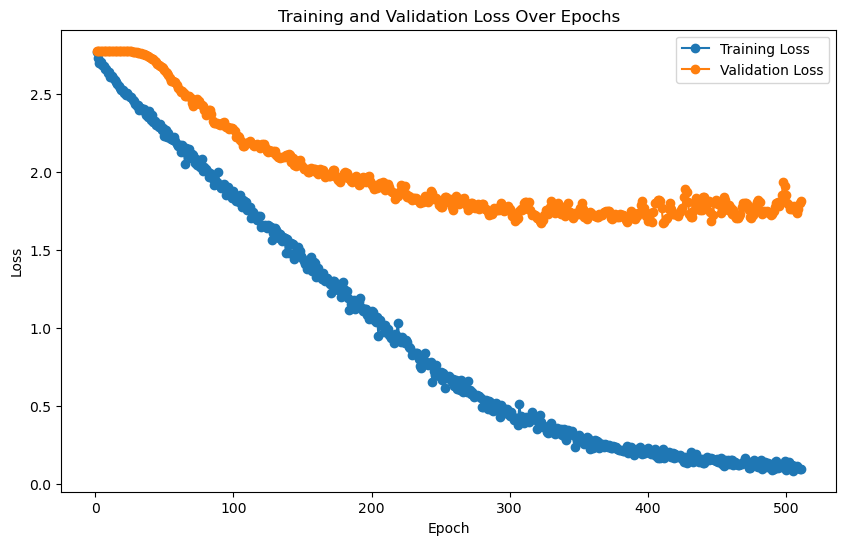

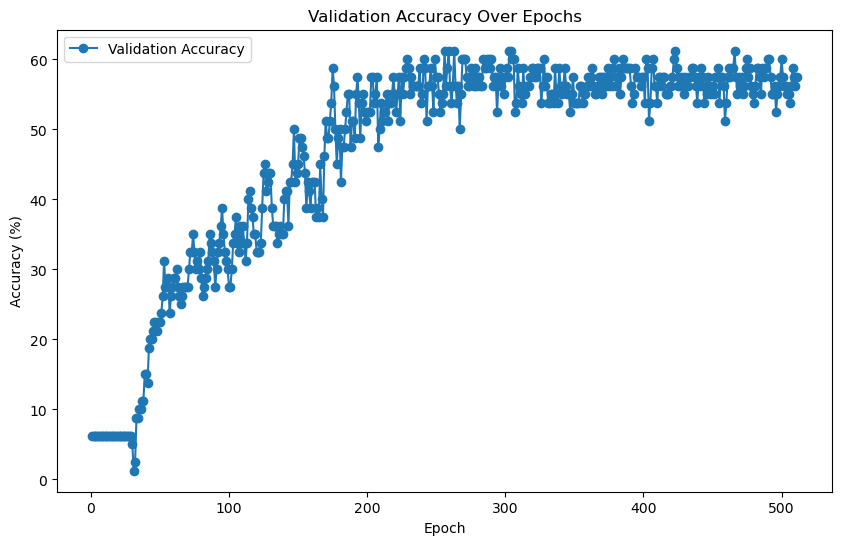


Evaluating on the test set...
    Test Batch [1/40], Loss: 4.1581

Final Test Loss: 2.0232, Test Accuracy: 46.68%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/40 for test dataset.
  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.
  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)

LOG: Training features shape: (80, 64), Training labels shape: (80,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (10089, 64), Test labels shape: (10089,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 48.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.00      0.00      0.00         5
           2       0.25      0.20      0.22         5
           3       0.33      0.20      0.25         5
           4       0.33      0.20      0.25         5
           5       0.38      0.60      0.46         5
           6       0.43      0.60      0.50         5
           7       0.40      0.40      0.40         5
           8       0.62      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)
Train reps shape: (80, 64)
Train labels shape: (80,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (10089, 64)
Test labels shape: (10089,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.0156  |  Val Loss: 2.8453
Validation loss improved from inf to 2.8453.
[Epoch 2/1000] Train Loss: 2.8766  |  Val Loss: 2.7905
Validation loss improved from 2.8453 to 2.7905.
[Epoch 3/1000] Train Loss: 2.7895  |  Val Loss: 2.7462
Validation loss improved from 2.7905 to 2.7462.
[Epoch 4/1000] Train Loss: 2.7198  |  Val Loss: 2.7225
Validation loss improved from 2.7462 to 2.7225.
[Epoch 5/1000] Train Loss: 2.6666  |  Val Loss: 2.7005
Validation loss improved from 2.7225 to 2.7005.
[Epoch 6/1000] Train Loss: 2.6160  |  Val Loss: 2.6693
Validation loss improved from 2.7005 to 2.6693.
[Epoch 7/1000] Train Loss: 2.5610  |  Val Loss: 2.6358
Validation loss improved from 2.6693 to 2.6358.
[Epoch 8/1000] Train Loss: 2.5100  |  Val Loss: 2.6106
Validation loss improved from 2.6358 to 2.6106.
[Epoch 9/1000] Train Loss: 2.4663  |  Val Loss: 2.5876
Validation loss improved from 2.6106 to 2.5876.
[Epoch 10/1000] Train Loss: 2.4287  |  Val Loss: 2.5597
Validation loss impr

[Epoch 16/1000] Train Loss: 2.2310  |  Val Loss: 2.4130
Validation loss improved from 2.4332 to 2.4130.
[Epoch 17/1000] Train Loss: 2.2006  |  Val Loss: 2.3891
Validation loss improved from 2.4130 to 2.3891.
[Epoch 18/1000] Train Loss: 2.1695  |  Val Loss: 2.3626
Validation loss improved from 2.3891 to 2.3626.
[Epoch 19/1000] Train Loss: 2.1398  |  Val Loss: 2.3390
Validation loss improved from 2.3626 to 2.3390.
[Epoch 20/1000] Train Loss: 2.1138  |  Val Loss: 2.3159
Validation loss improved from 2.3390 to 2.3159.
[Epoch 21/1000] Train Loss: 2.0837  |  Val Loss: 2.2950
Validation loss improved from 2.3159 to 2.2950.
[Epoch 22/1000] Train Loss: 2.0527  |  Val Loss: 2.2801
Validation loss improved from 2.2950 to 2.2801.
[Epoch 23/1000] Train Loss: 2.0262  |  Val Loss: 2.2700
Validation loss improved from 2.2801 to 2.2700.
[Epoch 24/1000] Train Loss: 2.0013  |  Val Loss: 2.2559
Validation loss improved from 2.2700 to 2.2559.
[Epoch 25/1000] Train Loss: 1.9733  |  Val Loss: 2.2330
Validati

[Epoch 30/1000] Train Loss: 1.8267  |  Val Loss: 2.1067
Validation loss improved from 2.1265 to 2.1067.
[Epoch 31/1000] Train Loss: 1.7972  |  Val Loss: 2.0926
Validation loss improved from 2.1067 to 2.0926.
[Epoch 32/1000] Train Loss: 1.7741  |  Val Loss: 2.0783
Validation loss improved from 2.0926 to 2.0783.
[Epoch 33/1000] Train Loss: 1.7461  |  Val Loss: 2.0575
Validation loss improved from 2.0783 to 2.0575.
[Epoch 34/1000] Train Loss: 1.7177  |  Val Loss: 2.0330
Validation loss improved from 2.0575 to 2.0330.
[Epoch 35/1000] Train Loss: 1.6904  |  Val Loss: 2.0053
Validation loss improved from 2.0330 to 2.0053.
[Epoch 36/1000] Train Loss: 1.6596  |  Val Loss: 1.9836
Validation loss improved from 2.0053 to 1.9836.
[Epoch 37/1000] Train Loss: 1.6326  |  Val Loss: 1.9658
Validation loss improved from 1.9836 to 1.9658.
[Epoch 38/1000] Train Loss: 1.6071  |  Val Loss: 1.9526
Validation loss improved from 1.9658 to 1.9526.
[Epoch 39/1000] Train Loss: 1.5791  |  Val Loss: 1.9375
Validati

[Epoch 40/1000] Train Loss: 1.5498  |  Val Loss: 1.9209
Validation loss improved from 1.9375 to 1.9209.
[Epoch 41/1000] Train Loss: 1.5149  |  Val Loss: 1.9096
Validation loss improved from 1.9209 to 1.9096.
[Epoch 42/1000] Train Loss: 1.4922  |  Val Loss: 1.9030
Validation loss improved from 1.9096 to 1.9030.
[Epoch 43/1000] Train Loss: 1.4785  |  Val Loss: 1.8919
Validation loss improved from 1.9030 to 1.8919.
[Epoch 44/1000] Train Loss: 1.4562  |  Val Loss: 1.8766
Validation loss improved from 1.8919 to 1.8766.
[Epoch 45/1000] Train Loss: 1.4299  |  Val Loss: 1.8582
Validation loss improved from 1.8766 to 1.8582.
[Epoch 46/1000] Train Loss: 1.4128  |  Val Loss: 1.8426
Validation loss improved from 1.8582 to 1.8426.
[Epoch 47/1000] Train Loss: 1.3808  |  Val Loss: 1.8254
Validation loss improved from 1.8426 to 1.8254.
[Epoch 48/1000] Train Loss: 1.3485  |  Val Loss: 1.8328
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 49/1000] Train Loss: 1.3416  |  Val Loss: 1.8490
!!

[Epoch 58/1000] Train Loss: 1.1997  |  Val Loss: 1.7915
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 59/1000] Train Loss: 1.1859  |  Val Loss: 1.7583
Validation loss improved from 1.7743 to 1.7583.
[Epoch 60/1000] Train Loss: 1.1536  |  Val Loss: 1.7383
Validation loss improved from 1.7583 to 1.7383.
[Epoch 61/1000] Train Loss: 1.1433  |  Val Loss: 1.7273
Validation loss improved from 1.7383 to 1.7273.
[Epoch 62/1000] Train Loss: 1.1261  |  Val Loss: 1.7239
Validation loss improved from 1.7273 to 1.7239.
[Epoch 63/1000] Train Loss: 1.1171  |  Val Loss: 1.7446
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 64/1000] Train Loss: 1.1157  |  Val Loss: 1.7454
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 65/1000] Train Loss: 1.0951  |  Val Loss: 1.7334
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 66/1000] Train Loss: 1.0794  |  Val Loss: 1.7396
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 67/1000] Train Loss: 1.0772

[Epoch 70/1000] Train Loss: 1.0374  |  Val Loss: 1.7461
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 71/1000] Train Loss: 1.0277  |  Val Loss: 1.7384
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 72/1000] Train Loss: 1.0188  |  Val Loss: 1.7486
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 73/1000] Train Loss: 1.0227  |  Val Loss: 1.7605
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 74/1000] Train Loss: 1.0189  |  Val Loss: 1.7407
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 75/1000] Train Loss: 0.9929  |  Val Loss: 1.7366
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 76/1000] Train Loss: 0.9768  |  Val Loss: 1.7586
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 77/1000] Train Loss: 0.9689  |  Val Loss: 1.7837
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 78/1000] Train Loss: 0.9638  |  Val Loss: 1.7856
!! Validation loss did NOT improve !! Patience: 16/100
[Ep

[Epoch 82/1000] Train Loss: 0.9051  |  Val Loss: 1.7259
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 83/1000] Train Loss: 0.9011  |  Val Loss: 1.7394
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 84/1000] Train Loss: 0.9041  |  Val Loss: 1.7428
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 85/1000] Train Loss: 0.8984  |  Val Loss: 1.7501
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 86/1000] Train Loss: 0.8853  |  Val Loss: 1.7621
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 87/1000] Train Loss: 0.8729  |  Val Loss: 1.7735
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 88/1000] Train Loss: 0.8587  |  Val Loss: 1.7554
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 89/1000] Train Loss: 0.8493  |  Val Loss: 1.7374
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 90/1000] Train Loss: 0.8455  |  Val Loss: 1.7321
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 91/

[Epoch 101/1000] Train Loss: 0.7673  |  Val Loss: 1.8058
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 102/1000] Train Loss: 0.7652  |  Val Loss: 1.7966
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 103/1000] Train Loss: 0.7618  |  Val Loss: 1.7777
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 104/1000] Train Loss: 0.7505  |  Val Loss: 1.7720
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 105/1000] Train Loss: 0.7408  |  Val Loss: 1.7899
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 106/1000] Train Loss: 0.7425  |  Val Loss: 1.8236
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 107/1000] Train Loss: 0.7465  |  Val Loss: 1.8286
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 108/1000] Train Loss: 0.7246  |  Val Loss: 1.8200
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 109/1000] Train Loss: 0.7089  |  Val Loss: 1.8451
!! Validation loss did NOT improve !! Patience:

[Epoch 112/1000] Train Loss: 0.7195  |  Val Loss: 1.8931
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 113/1000] Train Loss: 0.7094  |  Val Loss: 1.9157
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 114/1000] Train Loss: 0.7264  |  Val Loss: 1.8836
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 115/1000] Train Loss: 0.6969  |  Val Loss: 1.8503
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 116/1000] Train Loss: 0.6783  |  Val Loss: 1.8517
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 117/1000] Train Loss: 0.6766  |  Val Loss: 1.8612
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 118/1000] Train Loss: 0.6768  |  Val Loss: 1.8929
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 119/1000] Train Loss: 0.6978  |  Val Loss: 1.9133
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 120/1000] Train Loss: 0.7054  |  Val Loss: 1.8795
!! Validation loss did NOT improve !! Patience:

[Epoch 126/1000] Train Loss: 0.6497  |  Val Loss: 1.9736
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 127/1000] Train Loss: 0.6655  |  Val Loss: 1.9658
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 128/1000] Train Loss: 0.6590  |  Val Loss: 1.9345
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 129/1000] Train Loss: 0.6407  |  Val Loss: 1.8964
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 130/1000] Train Loss: 0.6111  |  Val Loss: 1.8867
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 131/1000] Train Loss: 0.6109  |  Val Loss: 1.9102
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 132/1000] Train Loss: 0.6264  |  Val Loss: 1.9274
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 133/1000] Train Loss: 0.6256  |  Val Loss: 1.9391
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 134/1000] Train Loss: 0.6061  |  Val Loss: 1.9682
!! Validation loss did NOT improve !! Patience:

[Epoch 141/1000] Train Loss: 0.5878  |  Val Loss: 1.9360
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 142/1000] Train Loss: 0.5719  |  Val Loss: 1.9682
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 143/1000] Train Loss: 0.5810  |  Val Loss: 1.9935
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 144/1000] Train Loss: 0.5841  |  Val Loss: 1.9787
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 145/1000] Train Loss: 0.5632  |  Val Loss: 1.9857
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 146/1000] Train Loss: 0.5584  |  Val Loss: 2.0258
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 147/1000] Train Loss: 0.5727  |  Val Loss: 2.0175
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 148/1000] Train Loss: 0.5485  |  Val Loss: 2.0093
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 149/1000] Train Loss: 0.5652  |  Val Loss: 2.0497
!! Validation loss did NOT improve !! Patience:

[Epoch 153/1000] Train Loss: 0.5364  |  Val Loss: 1.9735
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 154/1000] Train Loss: 0.5421  |  Val Loss: 1.9779
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 155/1000] Train Loss: 0.5515  |  Val Loss: 2.0001
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 156/1000] Train Loss: 0.5341  |  Val Loss: 2.0520
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 157/1000] Train Loss: 0.5193  |  Val Loss: 2.0837
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 158/1000] Train Loss: 0.5168  |  Val Loss: 2.0528
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 159/1000] Train Loss: 0.5029  |  Val Loss: 2.0181
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 160/1000] Train Loss: 0.5161  |  Val Loss: 2.0222
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 161/1000] Train Loss: 0.5247  |  Val Loss: 2.0541
!! Validation loss did NOT improve !! Patience:

[Epoch 168/1000] Train Loss: 0.5050  |  Val Loss: 2.0861
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 169/1000] Train Loss: 0.4933  |  Val Loss: 2.1279
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 170/1000] Train Loss: 0.4997  |  Val Loss: 2.1478
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 171/1000] Train Loss: 0.4999  |  Val Loss: 2.1568
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 172/1000] Train Loss: 0.5069  |  Val Loss: 2.1507
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 173/1000] Train Loss: 0.4897  |  Val Loss: 2.1447
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 174/1000] Train Loss: 0.4818  |  Val Loss: 2.1778
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 175/1000] Train Loss: 0.4988  |  Val Loss: 2.1780
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 176/1000] Train Loss: 0.4857  |  Val Loss: 2.1829
!! Validation loss did NOT improve !! Patience:

[Epoch 178/1000] Train Loss: 0.4663  |  Val Loss: 2.2399
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 179/1000] Train Loss: 0.4657  |  Val Loss: 2.2687
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 180/1000] Train Loss: 0.4768  |  Val Loss: 2.2562
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 181/1000] Train Loss: 0.4656  |  Val Loss: 2.2236
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 181 !!
No improvement for 100 epochs.


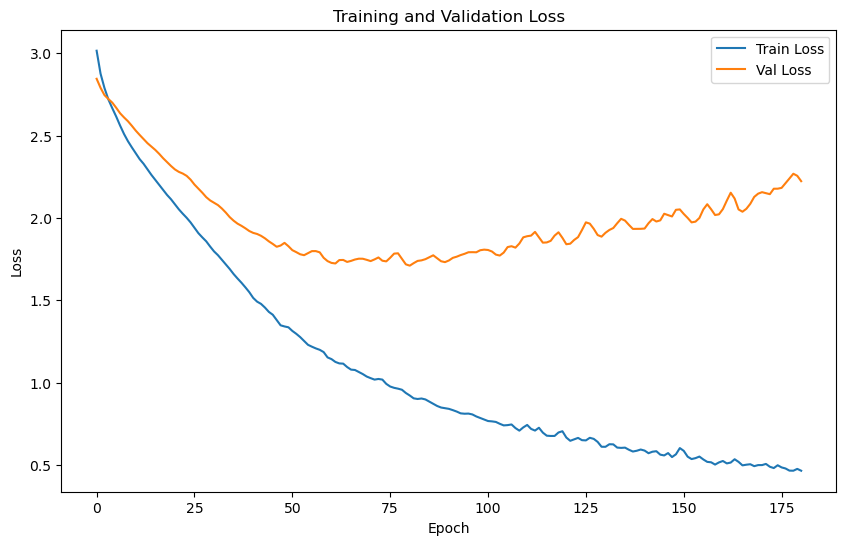

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.4305 | Test Accuracy: 39.91%


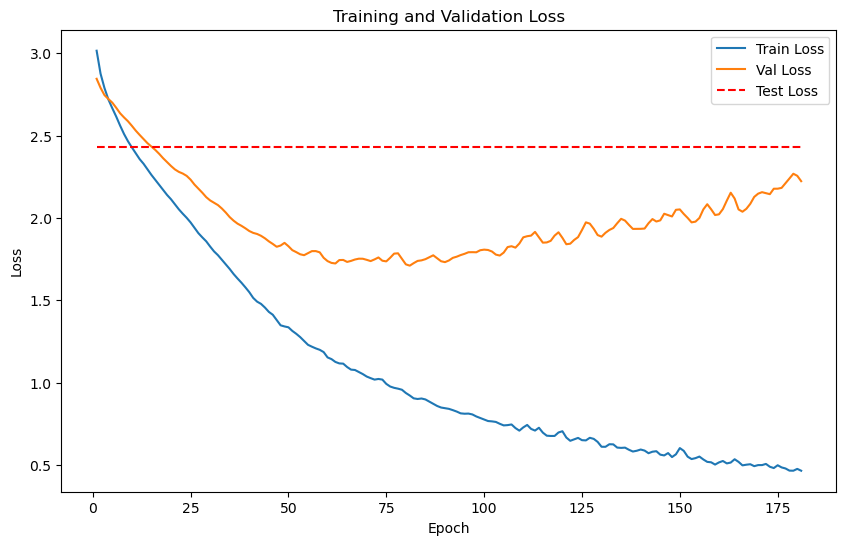

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10089, 64), 
Test labels shape: (10089,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 9.2271
Epoch [1/2000], Avg Train Loss: 9.2271
Epoch [1/2000], Avg Val Loss: 5.7920
Validation loss improved from inf to 5.7920. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.2456
Epoch [2/2000], Avg Train Loss: 9.2456
Epoch [2/2000], Avg Val Loss: 5.7371
Validation loss improved from 5.7920 to 5.7371. Saving model...

LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 9.0840
Epoch [3/2000], Avg Train Loss: 9.0840
Epoch [3/2000], Avg Val Loss: 5.6833
Validation loss improved from 5.7371 to 5.6833. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.7799
Epoch [4/2000], Avg Train Loss: 8.7799
Epoch [4/2000], Avg Val Loss: 5.6310
Validation loss improved from 5.6833 to 5.6310. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.6978
Epoch [5/2000], Avg Train Loss: 8.6978
Epoch [5/2000], Avg Val Loss: 5.5803
Validation loss improved from 5.6310 to 5.5803. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 9.0075
Epoch [6/2000], Avg Train Loss: 9.0075
Epoch [6/2000], Avg Val Loss: 5.5305
Validation loss improved from 5.5803 to 5.5305. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 8.8088
Epoch [7/2000], Avg Train Loss: 8.8088
Epoch [7/2000], Avg Val Loss: 5.4817
Validation loss improved from 5.5305 to 5.4817. Saving m

    Batch [1/1], Train Loss: 7.4946
Epoch [22/2000], Avg Train Loss: 7.4946
Epoch [22/2000], Avg Val Loss: 4.8652
Validation loss improved from 4.9000 to 4.8652. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.5214
Epoch [23/2000], Avg Train Loss: 7.5214
Epoch [23/2000], Avg Val Loss: 4.8311
Validation loss improved from 4.8652 to 4.8311. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 7.7923
Epoch [24/2000], Avg Train Loss: 7.7923
Epoch [24/2000], Avg Val Loss: 4.7977
Validation loss improved from 4.8311 to 4.7977. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 7.5972
Epoch [25/2000], Avg Train Loss: 7.5972
Epoch [25/2000], Avg Val Loss: 4.7651
Validation loss improved from 4.7977 to 4.7651. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 7.4205
Epoch [26/2000], Avg Train Loss: 7.4205
Epoch [26/2000], Avg Val Loss: 4.7332
Validation loss improved from 4.7651 to 4.

    Batch [1/1], Train Loss: 6.9773
Epoch [33/2000], Avg Train Loss: 6.9773
Epoch [33/2000], Avg Val Loss: 4.5301
Validation loss improved from 4.5570 to 4.5301. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.8993
Epoch [34/2000], Avg Train Loss: 6.8993
Epoch [34/2000], Avg Val Loss: 4.5040
Validation loss improved from 4.5301 to 4.5040. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 7.1281
Epoch [35/2000], Avg Train Loss: 7.1281
Epoch [35/2000], Avg Val Loss: 4.4787
Validation loss improved from 4.5040 to 4.4787. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 6.8606
Epoch [36/2000], Avg Train Loss: 6.8606
Epoch [36/2000], Avg Val Loss: 4.4538
Validation loss improved from 4.4787 to 4.4538. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 6.7885
Epoch [37/2000], Avg Train Loss: 6.7885
Epoch [37/2000], Avg Val Loss: 4.4296
Validation loss improved from 4.4538 to 4.

    Batch [1/1], Train Loss: 6.0274
Epoch [51/2000], Avg Train Loss: 6.0274
Epoch [51/2000], Avg Val Loss: 4.1531
Validation loss improved from 4.1695 to 4.1531. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 6.0945
Epoch [52/2000], Avg Train Loss: 6.0945
Epoch [52/2000], Avg Val Loss: 4.1371
Validation loss improved from 4.1531 to 4.1371. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 6.0025
Epoch [53/2000], Avg Train Loss: 6.0025
Epoch [53/2000], Avg Val Loss: 4.1217
Validation loss improved from 4.1371 to 4.1217. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.5997
Epoch [54/2000], Avg Train Loss: 5.5997
Epoch [54/2000], Avg Val Loss: 4.1068
Validation loss improved from 4.1217 to 4.1068. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.5575
Epoch [55/2000], Avg Train Loss: 5.5575
Epoch [55/2000], Avg Val Loss: 4.0925
Validation loss improved from 4.1068 to 4.

    Batch [1/1], Train Loss: 5.3447
Epoch [69/2000], Avg Train Loss: 5.3447
Epoch [69/2000], Avg Val Loss: 3.9289
Validation loss improved from 3.9385 to 3.9289. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.3317
Epoch [70/2000], Avg Train Loss: 5.3317
Epoch [70/2000], Avg Val Loss: 3.9196
Validation loss improved from 3.9289 to 3.9196. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.3376
Epoch [71/2000], Avg Train Loss: 5.3376
Epoch [71/2000], Avg Val Loss: 3.9106
Validation loss improved from 3.9196 to 3.9106. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.3503
Epoch [72/2000], Avg Train Loss: 5.3503
Epoch [72/2000], Avg Val Loss: 3.9019
Validation loss improved from 3.9106 to 3.9019. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.2123
Epoch [73/2000], Avg Train Loss: 5.2123
Epoch [73/2000], Avg Val Loss: 3.8934
Validation loss improved from 3.9019 to 3.

    Batch [1/1], Train Loss: 5.0700
Epoch [79/2000], Avg Train Loss: 5.0700
Epoch [79/2000], Avg Val Loss: 3.8477
Validation loss improved from 3.8547 to 3.8477. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 5.1894
Epoch [80/2000], Avg Train Loss: 5.1894
Epoch [80/2000], Avg Val Loss: 3.8410
Validation loss improved from 3.8477 to 3.8410. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 5.1152
Epoch [81/2000], Avg Train Loss: 5.1152
Epoch [81/2000], Avg Val Loss: 3.8344
Validation loss improved from 3.8410 to 3.8344. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 4.8147
Epoch [82/2000], Avg Train Loss: 4.8147
Epoch [82/2000], Avg Val Loss: 3.8280
Validation loss improved from 3.8344 to 3.8280. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 4.9863
Epoch [83/2000], Avg Train Loss: 4.9863
Epoch [83/2000], Avg Val Loss: 3.8218
Validation loss improved from 3.8280 to 3.

    Batch [1/1], Train Loss: 4.8202
Epoch [92/2000], Avg Train Loss: 4.8202
Epoch [92/2000], Avg Val Loss: 3.7730
Validation loss improved from 3.7778 to 3.7730. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 4.6040
Epoch [93/2000], Avg Train Loss: 4.6040
Epoch [93/2000], Avg Val Loss: 3.7683
Validation loss improved from 3.7730 to 3.7683. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.6528
Epoch [94/2000], Avg Train Loss: 4.6528
Epoch [94/2000], Avg Val Loss: 3.7637
Validation loss improved from 3.7683 to 3.7637. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.5690
Epoch [95/2000], Avg Train Loss: 4.5690
Epoch [95/2000], Avg Val Loss: 3.7594
Validation loss improved from 3.7637 to 3.7594. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.7517
Epoch [96/2000], Avg Train Loss: 4.7517
Epoch [96/2000], Avg Val Loss: 3.7551
Validation loss improved from 3.7594 to 3.

    Batch [1/1], Train Loss: 4.4750
Epoch [116/2000], Avg Train Loss: 4.4750
Epoch [116/2000], Avg Val Loss: 3.6906
Validation loss improved from 3.6931 to 3.6906. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.2697
Epoch [117/2000], Avg Train Loss: 4.2697
Epoch [117/2000], Avg Val Loss: 3.6881
Validation loss improved from 3.6906 to 3.6881. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.3254
Epoch [118/2000], Avg Train Loss: 4.3254
Epoch [118/2000], Avg Val Loss: 3.6857
Validation loss improved from 3.6881 to 3.6857. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.4476
Epoch [119/2000], Avg Train Loss: 4.4476
Epoch [119/2000], Avg Val Loss: 3.6834
Validation loss improved from 3.6857 to 3.6834. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.4590
Epoch [120/2000], Avg Train Loss: 4.4590
Epoch [120/2000], Avg Val Loss: 3.6812
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2640
Epoch [125/2000], Avg Train Loss: 4.2640
Epoch [125/2000], Avg Val Loss: 3.6708
Validation loss improved from 3.6728 to 3.6708. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.3202
Epoch [126/2000], Avg Train Loss: 4.3202
Epoch [126/2000], Avg Val Loss: 3.6689
Validation loss improved from 3.6708 to 3.6689. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.3008
Epoch [127/2000], Avg Train Loss: 4.3008
Epoch [127/2000], Avg Val Loss: 3.6669
Validation loss improved from 3.6689 to 3.6669. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.4077
Epoch [128/2000], Avg Train Loss: 4.4077
Epoch [128/2000], Avg Val Loss: 3.6651
Validation loss improved from 3.6669 to 3.6651. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.2305
Epoch [129/2000], Avg Train Loss: 4.2305
Epoch [129/2000], Avg Val Loss: 3.6632
Validation loss improved fro

Epoch [138/2000], Avg Val Loss: 3.6478
Validation loss improved from 3.6494 to 3.6478. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 4.1375
Epoch [139/2000], Avg Train Loss: 4.1375
Epoch [139/2000], Avg Val Loss: 3.6463
Validation loss improved from 3.6478 to 3.6463. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 4.3065
Epoch [140/2000], Avg Train Loss: 4.3065
Epoch [140/2000], Avg Val Loss: 3.6447
Validation loss improved from 3.6463 to 3.6447. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 4.1304
Epoch [141/2000], Avg Train Loss: 4.1304
Epoch [141/2000], Avg Val Loss: 3.6432
Validation loss improved from 3.6447 to 3.6432. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 4.2285
Epoch [142/2000], Avg Train Loss: 4.2285
Epoch [142/2000], Avg Val Loss: 3.6418
Validation loss improved from 3.6432 to 3.6418. Saving model...

LOG: Epoch [143/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0828
Epoch [159/2000], Avg Train Loss: 4.0828
Epoch [159/2000], Avg Val Loss: 3.6189
Validation loss improved from 3.6201 to 3.6189. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 4.0562
Epoch [160/2000], Avg Train Loss: 4.0562
Epoch [160/2000], Avg Val Loss: 3.6177
Validation loss improved from 3.6189 to 3.6177. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.0862
Epoch [161/2000], Avg Train Loss: 4.0862
Epoch [161/2000], Avg Val Loss: 3.6165
Validation loss improved from 3.6177 to 3.6165. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.1574
Epoch [162/2000], Avg Train Loss: 4.1574
Epoch [162/2000], Avg Val Loss: 3.6154
Validation loss improved from 3.6165 to 3.6154. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.0357
Epoch [163/2000], Avg Train Loss: 4.0357
Epoch [163/2000], Avg Val Loss: 3.6142
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0572
Epoch [173/2000], Avg Train Loss: 4.0572
Epoch [173/2000], Avg Val Loss: 3.6036
Validation loss improved from 3.6046 to 3.6036. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 4.1485
Epoch [174/2000], Avg Train Loss: 4.1485
Epoch [174/2000], Avg Val Loss: 3.6026
Validation loss improved from 3.6036 to 3.6026. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.0861
Epoch [175/2000], Avg Train Loss: 4.0861
Epoch [175/2000], Avg Val Loss: 3.6016
Validation loss improved from 3.6026 to 3.6016. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.0528
Epoch [176/2000], Avg Train Loss: 4.0528
Epoch [176/2000], Avg Val Loss: 3.6006
Validation loss improved from 3.6016 to 3.6006. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 3.9442
Epoch [177/2000], Avg Train Loss: 3.9442
Epoch [177/2000], Avg Val Loss: 3.5996
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0310
Epoch [184/2000], Avg Train Loss: 4.0310
Epoch [184/2000], Avg Val Loss: 3.5928
Validation loss improved from 3.5938 to 3.5928. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 4.0525
Epoch [185/2000], Avg Train Loss: 4.0525
Epoch [185/2000], Avg Val Loss: 3.5919
Validation loss improved from 3.5928 to 3.5919. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 3.9540
Epoch [186/2000], Avg Train Loss: 3.9540
Epoch [186/2000], Avg Val Loss: 3.5909
Validation loss improved from 3.5919 to 3.5909. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 4.0398
Epoch [187/2000], Avg Train Loss: 4.0398
Epoch [187/2000], Avg Val Loss: 3.5900
Validation loss improved from 3.5909 to 3.5900. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 3.9825
Epoch [188/2000], Avg Train Loss: 3.9825
Epoch [188/2000], Avg Val Loss: 3.5890
Validation loss improved fro

Epoch [204/2000], Avg Val Loss: 3.5747
Validation loss improved from 3.5756 to 3.5747. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 3.9660
Epoch [205/2000], Avg Train Loss: 3.9660
Epoch [205/2000], Avg Val Loss: 3.5739
Validation loss improved from 3.5747 to 3.5739. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 3.9666
Epoch [206/2000], Avg Train Loss: 3.9666
Epoch [206/2000], Avg Val Loss: 3.5730
Validation loss improved from 3.5739 to 3.5730. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 3.9577
Epoch [207/2000], Avg Train Loss: 3.9577
Epoch [207/2000], Avg Val Loss: 3.5722
Validation loss improved from 3.5730 to 3.5722. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 3.8380
Epoch [208/2000], Avg Train Loss: 3.8380
Epoch [208/2000], Avg Val Loss: 3.5713
Validation loss improved from 3.5722 to 3.5713. Saving model...

LOG: Epoch [209/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8343
Epoch [221/2000], Avg Train Loss: 3.8343
Epoch [221/2000], Avg Val Loss: 3.5610
Validation loss improved from 3.5618 to 3.5610. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 3.9914
Epoch [222/2000], Avg Train Loss: 3.9914
Epoch [222/2000], Avg Val Loss: 3.5603
Validation loss improved from 3.5610 to 3.5603. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 3.8050
Epoch [223/2000], Avg Train Loss: 3.8050
Epoch [223/2000], Avg Val Loss: 3.5596
Validation loss improved from 3.5603 to 3.5596. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 3.8812
Epoch [224/2000], Avg Train Loss: 3.8812
Epoch [224/2000], Avg Val Loss: 3.5589
Validation loss improved from 3.5596 to 3.5589. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 3.8896
Epoch [225/2000], Avg Train Loss: 3.8896
Epoch [225/2000], Avg Val Loss: 3.5581
Validation loss improved fro

Epoch [228/2000], Avg Val Loss: 3.5560
Validation loss improved from 3.5567 to 3.5560. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 3.7821
Epoch [229/2000], Avg Train Loss: 3.7821
Epoch [229/2000], Avg Val Loss: 3.5553
Validation loss improved from 3.5560 to 3.5553. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 3.8527
Epoch [230/2000], Avg Train Loss: 3.8527
Epoch [230/2000], Avg Val Loss: 3.5546
Validation loss improved from 3.5553 to 3.5546. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 3.8300
Epoch [231/2000], Avg Train Loss: 3.8300
Epoch [231/2000], Avg Val Loss: 3.5539
Validation loss improved from 3.5546 to 3.5539. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 3.8815
Epoch [232/2000], Avg Train Loss: 3.8815
Epoch [232/2000], Avg Val Loss: 3.5531
Validation loss improved from 3.5539 to 3.5531. Saving model...

LOG: Epoch [233/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7388
Epoch [251/2000], Avg Train Loss: 3.7388
Epoch [251/2000], Avg Val Loss: 3.5400
Validation loss improved from 3.5407 to 3.5400. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 3.7877
Epoch [252/2000], Avg Train Loss: 3.7877
Epoch [252/2000], Avg Val Loss: 3.5393
Validation loss improved from 3.5400 to 3.5393. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 3.8304
Epoch [253/2000], Avg Train Loss: 3.8304
Epoch [253/2000], Avg Val Loss: 3.5386
Validation loss improved from 3.5393 to 3.5386. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 3.7469
Epoch [254/2000], Avg Train Loss: 3.7469
Epoch [254/2000], Avg Val Loss: 3.5380
Validation loss improved from 3.5386 to 3.5380. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 3.8202
Epoch [255/2000], Avg Train Loss: 3.8202
Epoch [255/2000], Avg Val Loss: 3.5373
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7075
Epoch [269/2000], Avg Train Loss: 3.7075


Epoch [269/2000], Avg Val Loss: 3.5278
Validation loss improved from 3.5285 to 3.5278. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 3.7775
Epoch [270/2000], Avg Train Loss: 3.7775
Epoch [270/2000], Avg Val Loss: 3.5271
Validation loss improved from 3.5278 to 3.5271. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 3.8151
Epoch [271/2000], Avg Train Loss: 3.8151
Epoch [271/2000], Avg Val Loss: 3.5265
Validation loss improved from 3.5271 to 3.5265. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 3.7671
Epoch [272/2000], Avg Train Loss: 3.7671
Epoch [272/2000], Avg Val Loss: 3.5258
Validation loss improved from 3.5265 to 3.5258. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 3.8094
Epoch [273/2000], Avg Train Loss: 3.8094
Epoch [273/2000], Avg Val Loss: 3.5251
Validation loss improved from 3.5258 to 3.5251. Saving model...

LOG: Epoch [274/2000] - Training
    Bat

Epoch [298/2000], Avg Val Loss: 3.5088
Validation loss improved from 3.5094 to 3.5088. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.7210
Epoch [299/2000], Avg Train Loss: 3.7210
Epoch [299/2000], Avg Val Loss: 3.5082
Validation loss improved from 3.5088 to 3.5082. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.7498
Epoch [300/2000], Avg Train Loss: 3.7498
Epoch [300/2000], Avg Val Loss: 3.5075
Validation loss improved from 3.5082 to 3.5075. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 3.6699
Epoch [301/2000], Avg Train Loss: 3.6699
Epoch [301/2000], Avg Val Loss: 3.5069
Validation loss improved from 3.5075 to 3.5069. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 3.7018
Epoch [302/2000], Avg Train Loss: 3.7018
Epoch [302/2000], Avg Val Loss: 3.5063
Validation loss improved from 3.5069 to 3.5063. Saving model...

LOG: Epoch [303/2000] - Training
    Bat

Epoch [318/2000], Avg Val Loss: 3.4969
Validation loss improved from 3.4975 to 3.4969. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 3.6015
Epoch [319/2000], Avg Train Loss: 3.6015
Epoch [319/2000], Avg Val Loss: 3.4964
Validation loss improved from 3.4969 to 3.4964. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 3.6757
Epoch [320/2000], Avg Train Loss: 3.6757
Epoch [320/2000], Avg Val Loss: 3.4958
Validation loss improved from 3.4964 to 3.4958. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 3.6900
Epoch [321/2000], Avg Train Loss: 3.6900
Epoch [321/2000], Avg Val Loss: 3.4953
Validation loss improved from 3.4958 to 3.4953. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 3.7001
Epoch [322/2000], Avg Train Loss: 3.7001
Epoch [322/2000], Avg Val Loss: 3.4947
Validation loss improved from 3.4953 to 3.4947. Saving model...

LOG: Epoch [323/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5991
Epoch [342/2000], Avg Train Loss: 3.5991
Epoch [342/2000], Avg Val Loss: 3.4837
Validation loss improved from 3.4842 to 3.4837. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 3.6110
Epoch [343/2000], Avg Train Loss: 3.6110
Epoch [343/2000], Avg Val Loss: 3.4832
Validation loss improved from 3.4837 to 3.4832. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 3.6216
Epoch [344/2000], Avg Train Loss: 3.6216
Epoch [344/2000], Avg Val Loss: 3.4827
Validation loss improved from 3.4832 to 3.4827. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 3.6729
Epoch [345/2000], Avg Train Loss: 3.6729
Epoch [345/2000], Avg Val Loss: 3.4821
Validation loss improved from 3.4827 to 3.4821. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 3.5940
Epoch [346/2000], Avg Train Loss: 3.5940
Epoch [346/2000], Avg Val Loss: 3.4816
Validation loss improved fro

Epoch [364/2000], Avg Val Loss: 3.4728
Validation loss improved from 3.4733 to 3.4728. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 3.5746
Epoch [365/2000], Avg Train Loss: 3.5746
Epoch [365/2000], Avg Val Loss: 3.4723
Validation loss improved from 3.4728 to 3.4723. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 3.5952
Epoch [366/2000], Avg Train Loss: 3.5952
Epoch [366/2000], Avg Val Loss: 3.4718
Validation loss improved from 3.4723 to 3.4718. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 3.5896
Epoch [367/2000], Avg Train Loss: 3.5896
Epoch [367/2000], Avg Val Loss: 3.4713
Validation loss improved from 3.4718 to 3.4713. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 3.6313
Epoch [368/2000], Avg Train Loss: 3.6313
Epoch [368/2000], Avg Val Loss: 3.4708
Validation loss improved from 3.4713 to 3.4708. Saving model...

LOG: Epoch [369/2000] - Training
    Bat

Epoch [387/2000], Avg Val Loss: 3.4617
Validation loss improved from 3.4621 to 3.4617. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 3.5251
Epoch [388/2000], Avg Train Loss: 3.5251
Epoch [388/2000], Avg Val Loss: 3.4612
Validation loss improved from 3.4617 to 3.4612. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 3.6295
Epoch [389/2000], Avg Train Loss: 3.6295
Epoch [389/2000], Avg Val Loss: 3.4608
Validation loss improved from 3.4612 to 3.4608. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 3.5126
Epoch [390/2000], Avg Train Loss: 3.5126
Epoch [390/2000], Avg Val Loss: 3.4604
Validation loss improved from 3.4608 to 3.4604. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 3.4712
Epoch [391/2000], Avg Train Loss: 3.4712
Epoch [391/2000], Avg Val Loss: 3.4600
Validation loss improved from 3.4604 to 3.4600. Saving model...

LOG: Epoch [392/2000] - Training
    Bat

Epoch [411/2000], Avg Val Loss: 3.4518
Validation loss improved from 3.4522 to 3.4518. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 3.4986
Epoch [412/2000], Avg Train Loss: 3.4986
Epoch [412/2000], Avg Val Loss: 3.4514
Validation loss improved from 3.4518 to 3.4514. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 3.5558
Epoch [413/2000], Avg Train Loss: 3.5558
Epoch [413/2000], Avg Val Loss: 3.4510
Validation loss improved from 3.4514 to 3.4510. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 3.5663
Epoch [414/2000], Avg Train Loss: 3.5663
Epoch [414/2000], Avg Val Loss: 3.4506
Validation loss improved from 3.4510 to 3.4506. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 3.5331
Epoch [415/2000], Avg Train Loss: 3.5331
Epoch [415/2000], Avg Val Loss: 3.4502
Validation loss improved from 3.4506 to 3.4502. Saving model...

LOG: Epoch [416/2000] - Training
    Bat

Epoch [432/2000], Avg Val Loss: 3.4441
Validation loss improved from 3.4444 to 3.4441. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 3.4833
Epoch [433/2000], Avg Train Loss: 3.4833
Epoch [433/2000], Avg Val Loss: 3.4438
Validation loss improved from 3.4441 to 3.4438. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 3.4637
Epoch [434/2000], Avg Train Loss: 3.4637
Epoch [434/2000], Avg Val Loss: 3.4434
Validation loss improved from 3.4438 to 3.4434. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 3.4391
Epoch [435/2000], Avg Train Loss: 3.4391
Epoch [435/2000], Avg Val Loss: 3.4431
Validation loss improved from 3.4434 to 3.4431. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 3.4954
Epoch [436/2000], Avg Train Loss: 3.4954
Epoch [436/2000], Avg Val Loss: 3.4428
Validation loss improved from 3.4431 to 3.4428. Saving model...

LOG: Epoch [437/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4861
Epoch [460/2000], Avg Train Loss: 3.4861
Epoch [460/2000], Avg Val Loss: 3.4356
Validation loss improved from 3.4359 to 3.4356. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 3.5172
Epoch [461/2000], Avg Train Loss: 3.5172
Epoch [461/2000], Avg Val Loss: 3.4353
Validation loss improved from 3.4356 to 3.4353. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 3.4290
Epoch [462/2000], Avg Train Loss: 3.4290
Epoch [462/2000], Avg Val Loss: 3.4350
Validation loss improved from 3.4353 to 3.4350. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 3.3951
Epoch [463/2000], Avg Train Loss: 3.3951
Epoch [463/2000], Avg Val Loss: 3.4347
Validation loss improved from 3.4350 to 3.4347. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 3.4680
Epoch [464/2000], Avg Train Loss: 3.4680
Epoch [464/2000], Avg Val Loss: 3.4345
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4458
Epoch [478/2000], Avg Train Loss: 3.4458
Epoch [478/2000], Avg Val Loss: 3.4305
Validation loss improved from 3.4308 to 3.4305. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 3.4061
Epoch [479/2000], Avg Train Loss: 3.4061
Epoch [479/2000], Avg Val Loss: 3.4302
Validation loss improved from 3.4305 to 3.4302. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 3.4197
Epoch [480/2000], Avg Train Loss: 3.4197
Epoch [480/2000], Avg Val Loss: 3.4299
Validation loss improved from 3.4302 to 3.4299. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 3.4126
Epoch [481/2000], Avg Train Loss: 3.4126
Epoch [481/2000], Avg Val Loss: 3.4296
Validation loss improved from 3.4299 to 3.4296. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 3.4431
Epoch [482/2000], Avg Train Loss: 3.4431
Epoch [482/2000], Avg Val Loss: 3.4294
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4221
Epoch [503/2000], Avg Train Loss: 3.4221
Epoch [503/2000], Avg Val Loss: 3.4248
Validation loss improved from 3.4250 to 3.4248. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 3.5087
Epoch [504/2000], Avg Train Loss: 3.5087
Epoch [504/2000], Avg Val Loss: 3.4247
Validation loss improved from 3.4248 to 3.4247. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 3.4223
Epoch [505/2000], Avg Train Loss: 3.4223
Epoch [505/2000], Avg Val Loss: 3.4245
Validation loss improved from 3.4247 to 3.4245. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 3.4531
Epoch [506/2000], Avg Train Loss: 3.4531
Epoch [506/2000], Avg Val Loss: 3.4243
Validation loss improved from 3.4245 to 3.4243. Saving model...

LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 3.4225
Epoch [507/2000], Avg Train Loss: 3.4225
Epoch [507/2000], Avg Val Loss: 3.4242
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4244
Epoch [522/2000], Avg Train Loss: 3.4244
Epoch [522/2000], Avg Val Loss: 3.4214
Validation loss improved from 3.4217 to 3.4214. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 3.4229
Epoch [523/2000], Avg Train Loss: 3.4229
Epoch [523/2000], Avg Val Loss: 3.4212
Validation loss improved from 3.4214 to 3.4212. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 3.3296
Epoch [524/2000], Avg Train Loss: 3.3296
Epoch [524/2000], Avg Val Loss: 3.4210
Validation loss improved from 3.4212 to 3.4210. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 3.3524
Epoch [525/2000], Avg Train Loss: 3.3524
Epoch [525/2000], Avg Val Loss: 3.4208
Validation loss improved from 3.4210 to 3.4208. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 3.4051
Epoch [526/2000], Avg Train Loss: 3.4051
Epoch [526/2000], Avg Val Loss: 3.4206
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3208
Epoch [547/2000], Avg Train Loss: 3.3208
Epoch [547/2000], Avg Val Loss: 3.4185
Validation loss improved from 3.4186 to 3.4185. Saving model...

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 3.3600
Epoch [548/2000], Avg Train Loss: 3.3600
Epoch [548/2000], Avg Val Loss: 3.4184
Validation loss improved from 3.4185 to 3.4184. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 3.3788
Epoch [549/2000], Avg Train Loss: 3.3788
Epoch [549/2000], Avg Val Loss: 3.4183
Validation loss improved from 3.4184 to 3.4183. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 3.3069
Epoch [550/2000], Avg Train Loss: 3.3069
Epoch [550/2000], Avg Val Loss: 3.4183
Validation loss improved from 3.4183 to 3.4183. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 3.3904
Epoch [551/2000], Avg Train Loss: 3.3904
Epoch [551/2000], Avg Val Loss: 3.4182
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3267
Epoch [568/2000], Avg Train Loss: 3.3267
Epoch [568/2000], Avg Val Loss: 3.4171
Validation loss improved from 3.4173 to 3.4171. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 3.3791
Epoch [569/2000], Avg Train Loss: 3.3791
Epoch [569/2000], Avg Val Loss: 3.4170
Validation loss improved from 3.4171 to 3.4170. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 3.3080
Epoch [570/2000], Avg Train Loss: 3.3080
Epoch [570/2000], Avg Val Loss: 3.4169
Validation loss improved from 3.4170 to 3.4169. Saving model...

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 3.3678
Epoch [571/2000], Avg Train Loss: 3.3678
Epoch [571/2000], Avg Val Loss: 3.4168
Validation loss improved from 3.4169 to 3.4168. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 3.3642
Epoch [572/2000], Avg Train Loss: 3.3642
Epoch [572/2000], Avg Val Loss: 3.4167
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3173
Epoch [590/2000], Avg Train Loss: 3.3173
Epoch [590/2000], Avg Val Loss: 3.4153
Validation loss improved from 3.4154 to 3.4153. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 3.3975
Epoch [591/2000], Avg Train Loss: 3.3975
Epoch [591/2000], Avg Val Loss: 3.4152
Validation loss improved from 3.4153 to 3.4152. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 3.3089
Epoch [592/2000], Avg Train Loss: 3.3089
Epoch [592/2000], Avg Val Loss: 3.4151
Validation loss improved from 3.4152 to 3.4151. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 3.2930
Epoch [593/2000], Avg Train Loss: 3.2930
Epoch [593/2000], Avg Val Loss: 3.4150
Validation loss improved from 3.4151 to 3.4150. Saving model...

LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 3.3148
Epoch [594/2000], Avg Train Loss: 3.3148
Epoch [594/2000], Avg Val Loss: 3.4148
Validation loss improved fro

Epoch [611/2000], Avg Val Loss: 3.4143
Validation loss did not improve. Patience: 8/100

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 3.2911
Epoch [612/2000], Avg Train Loss: 3.2911
Epoch [612/2000], Avg Val Loss: 3.4143
Validation loss did not improve. Patience: 9/100

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 3.2287
Epoch [613/2000], Avg Train Loss: 3.2287
Epoch [613/2000], Avg Val Loss: 3.4143
Validation loss did not improve. Patience: 10/100

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 3.2721
Epoch [614/2000], Avg Train Loss: 3.2721
Epoch [614/2000], Avg Val Loss: 3.4143
Validation loss did not improve. Patience: 11/100

LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 3.2534
Epoch [615/2000], Avg Train Loss: 3.2534
Epoch [615/2000], Avg Val Loss: 3.4143
Validation loss did not improve. Patience: 12/100

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 3.3178
Epoch [616/2000], Avg Train Loss: 3.3178
Ep

    Batch [1/1], Train Loss: 3.2368
Epoch [634/2000], Avg Train Loss: 3.2368
Epoch [634/2000], Avg Val Loss: 3.4155
Validation loss did not improve. Patience: 31/100

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 3.2938
Epoch [635/2000], Avg Train Loss: 3.2938
Epoch [635/2000], Avg Val Loss: 3.4155
Validation loss did not improve. Patience: 32/100

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 3.2803
Epoch [636/2000], Avg Train Loss: 3.2803
Epoch [636/2000], Avg Val Loss: 3.4155
Validation loss did not improve. Patience: 33/100

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 3.2720
Epoch [637/2000], Avg Train Loss: 3.2720
Epoch [637/2000], Avg Val Loss: 3.4156
Validation loss did not improve. Patience: 34/100

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 3.2596
Epoch [638/2000], Avg Train Loss: 3.2596
Epoch [638/2000], Avg Val Loss: 3.4157
Validation loss did not improve. Patience: 35/100

LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 3.1685
Epoch [658/2000], Avg Train Loss: 3.1685
Epoch [658/2000], Avg Val Loss: 3.4179
Validation loss did not improve. Patience: 55/100

LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 3.2389
Epoch [659/2000], Avg Train Loss: 3.2389
Epoch [659/2000], Avg Val Loss: 3.4180
Validation loss did not improve. Patience: 56/100

LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 3.2344
Epoch [660/2000], Avg Train Loss: 3.2344
Epoch [660/2000], Avg Val Loss: 3.4181
Validation loss did not improve. Patience: 57/100

LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 3.2261
Epoch [661/2000], Avg Train Loss: 3.2261
Epoch [661/2000], Avg Val Loss: 3.4182
Validation loss did not improve. Patience: 58/100

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 3.2203
Epoch [662/2000], Avg Train Loss: 3.2203
Epoch [662/2000], Avg Val Loss: 3.4183
Validation loss did not improve. Patience: 59/100

LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 3.2428
Epoch [682/2000], Avg Train Loss: 3.2428
Epoch [682/2000], Avg Val Loss: 3.4219
Validation loss did not improve. Patience: 79/100

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 3.2085
Epoch [683/2000], Avg Train Loss: 3.2085
Epoch [683/2000], Avg Val Loss: 3.4222
Validation loss did not improve. Patience: 80/100

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 3.2074
Epoch [684/2000], Avg Train Loss: 3.2074
Epoch [684/2000], Avg Val Loss: 3.4224
Validation loss did not improve. Patience: 81/100

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 3.2728
Epoch [685/2000], Avg Train Loss: 3.2728
Epoch [685/2000], Avg Val Loss: 3.4227
Validation loss did not improve. Patience: 82/100

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 3.1889
Epoch [686/2000], Avg Train Loss: 3.1889
Epoch [686/2000], Avg Val Loss: 3.4230
Validation loss did not improve. Patience: 83/100

LOG: Epoch [687/2000] - Training


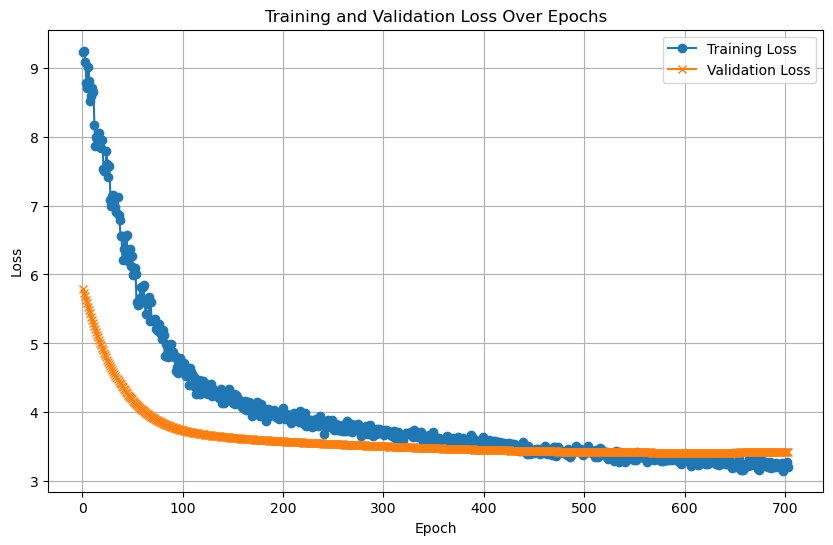

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/40], Loss: 5.0171
Test Batch [20/40], Loss: 4.8593
Test Batch [30/40], Loss: 4.7855
Test Batch [40/40], Loss: 5.0175

Test Loss: 4.8831


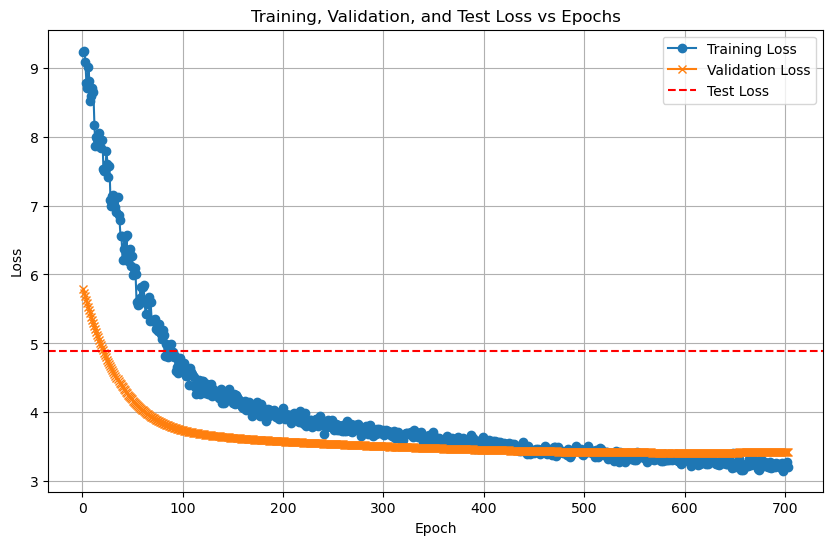

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/40 for test dataset.


  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.
  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 50.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.00      0.00      0.00         5
           2       0.25      0.20      0.22         5
           3       0.33      0.40      0.36         5
           4       0.33      0.20      0.25         5
           5       0.33      0.60      0.43         5
           6       0.50      0.80      0.62         5
           7       0.50      0.20      0.29         5
           8       0.71      1.00      0.83         5
           9       0.30      0.60      0.40         5
          10       0.60      0.60      0.60         5
          11       0.00      0.00      0.00         5
          12       0.80      0.80      0.80         5
          13       0.5

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8416  |  Val Loss: 2.8669
Validation loss improved from inf to 2.8669.
[Epoch 2/1000] Train Loss: 2.8318  |  Val Loss: 2.8608
Validation loss improved from 2.8669 to 2.8608.
[Epoch 3/1000] Train Loss: 2.8238  |  Val Loss: 2.8543
Validation loss improved from 2.8608 to 2.8543.
[Epoch 4/1000] Train Loss: 2.8155  |  Val Loss: 2.8478
Validation loss improved from 2.8543 to 2.8478.
[Epoch 5/1000] Train Loss: 2.8065  |  Val Loss: 2.8413
Validation loss improved from 2.8478 to 2.8413.
[Epoch 6/1000] Train Loss: 2.7989  |  Val Loss: 2.8348
Validation loss improved from 2.8413 to 2.8348.
[Epoch 7/1000] Train Loss: 2.7917  |  Val Loss: 2.8283
Validation loss improved from 2.8348 to 2.8283.
[Epoch 8/1000] Train Loss: 2.7841  |  Val Loss: 2.8220
Validation loss improved from 2.8283 to 2.8220.
[Epoch 9/1000] Train Loss: 2.7766  |  Val Loss: 2.8161
Validation loss improved from 2.8220 to 2.8161.
[Epoch 10/1000] Train Loss: 2.7692  |  Val Loss: 2.8103
Validation loss impr

[Epoch 19/1000] Train Loss: 2.7057  |  Val Loss: 2.7626
Validation loss improved from 2.7677 to 2.7626.
[Epoch 20/1000] Train Loss: 2.6987  |  Val Loss: 2.7577
Validation loss improved from 2.7626 to 2.7577.
[Epoch 21/1000] Train Loss: 2.6925  |  Val Loss: 2.7529
Validation loss improved from 2.7577 to 2.7529.
[Epoch 22/1000] Train Loss: 2.6854  |  Val Loss: 2.7482
Validation loss improved from 2.7529 to 2.7482.
[Epoch 23/1000] Train Loss: 2.6791  |  Val Loss: 2.7435
Validation loss improved from 2.7482 to 2.7435.
[Epoch 24/1000] Train Loss: 2.6729  |  Val Loss: 2.7388
Validation loss improved from 2.7435 to 2.7388.
[Epoch 25/1000] Train Loss: 2.6667  |  Val Loss: 2.7340
Validation loss improved from 2.7388 to 2.7340.
[Epoch 26/1000] Train Loss: 2.6602  |  Val Loss: 2.7294
Validation loss improved from 2.7340 to 2.7294.
[Epoch 27/1000] Train Loss: 2.6549  |  Val Loss: 2.7248
Validation loss improved from 2.7294 to 2.7248.
[Epoch 28/1000] Train Loss: 2.6489  |  Val Loss: 2.7204
Validati

[Epoch 37/1000] Train Loss: 2.5992  |  Val Loss: 2.6795
Validation loss improved from 2.6839 to 2.6795.
[Epoch 38/1000] Train Loss: 2.5938  |  Val Loss: 2.6751
Validation loss improved from 2.6795 to 2.6751.
[Epoch 39/1000] Train Loss: 2.5887  |  Val Loss: 2.6708
Validation loss improved from 2.6751 to 2.6708.
[Epoch 40/1000] Train Loss: 2.5838  |  Val Loss: 2.6665
Validation loss improved from 2.6708 to 2.6665.
[Epoch 41/1000] Train Loss: 2.5786  |  Val Loss: 2.6622
Validation loss improved from 2.6665 to 2.6622.
[Epoch 42/1000] Train Loss: 2.5736  |  Val Loss: 2.6579
Validation loss improved from 2.6622 to 2.6579.
[Epoch 43/1000] Train Loss: 2.5687  |  Val Loss: 2.6537
Validation loss improved from 2.6579 to 2.6537.
[Epoch 44/1000] Train Loss: 2.5636  |  Val Loss: 2.6497
Validation loss improved from 2.6537 to 2.6497.
[Epoch 45/1000] Train Loss: 2.5585  |  Val Loss: 2.6457
Validation loss improved from 2.6497 to 2.6457.
[Epoch 46/1000] Train Loss: 2.5538  |  Val Loss: 2.6416
Validati

[Epoch 62/1000] Train Loss: 2.4749  |  Val Loss: 2.5802
Validation loss improved from 2.5838 to 2.5802.
[Epoch 63/1000] Train Loss: 2.4699  |  Val Loss: 2.5766
Validation loss improved from 2.5802 to 2.5766.
[Epoch 64/1000] Train Loss: 2.4649  |  Val Loss: 2.5728
Validation loss improved from 2.5766 to 2.5728.
[Epoch 65/1000] Train Loss: 2.4602  |  Val Loss: 2.5691
Validation loss improved from 2.5728 to 2.5691.
[Epoch 66/1000] Train Loss: 2.4550  |  Val Loss: 2.5653
Validation loss improved from 2.5691 to 2.5653.
[Epoch 67/1000] Train Loss: 2.4500  |  Val Loss: 2.5617
Validation loss improved from 2.5653 to 2.5617.
[Epoch 68/1000] Train Loss: 2.4451  |  Val Loss: 2.5582
Validation loss improved from 2.5617 to 2.5582.
[Epoch 69/1000] Train Loss: 2.4398  |  Val Loss: 2.5547
Validation loss improved from 2.5582 to 2.5547.
[Epoch 70/1000] Train Loss: 2.4350  |  Val Loss: 2.5511
Validation loss improved from 2.5547 to 2.5511.
[Epoch 71/1000] Train Loss: 2.4298  |  Val Loss: 2.5473
Validati

[Epoch 79/1000] Train Loss: 2.3883  |  Val Loss: 2.5179
Validation loss improved from 2.5214 to 2.5179.
[Epoch 80/1000] Train Loss: 2.3831  |  Val Loss: 2.5144
Validation loss improved from 2.5179 to 2.5144.
[Epoch 81/1000] Train Loss: 2.3779  |  Val Loss: 2.5108
Validation loss improved from 2.5144 to 2.5108.
[Epoch 82/1000] Train Loss: 2.3726  |  Val Loss: 2.5070
Validation loss improved from 2.5108 to 2.5070.
[Epoch 83/1000] Train Loss: 2.3674  |  Val Loss: 2.5029
Validation loss improved from 2.5070 to 2.5029.
[Epoch 84/1000] Train Loss: 2.3618  |  Val Loss: 2.4988
Validation loss improved from 2.5029 to 2.4988.
[Epoch 85/1000] Train Loss: 2.3567  |  Val Loss: 2.4949
Validation loss improved from 2.4988 to 2.4949.
[Epoch 86/1000] Train Loss: 2.3513  |  Val Loss: 2.4909
Validation loss improved from 2.4949 to 2.4909.
[Epoch 87/1000] Train Loss: 2.3463  |  Val Loss: 2.4872
Validation loss improved from 2.4909 to 2.4872.
[Epoch 88/1000] Train Loss: 2.3408  |  Val Loss: 2.4837
Validati

[Epoch 102/1000] Train Loss: 2.2658  |  Val Loss: 2.4342
Validation loss improved from 2.4376 to 2.4342.
[Epoch 103/1000] Train Loss: 2.2604  |  Val Loss: 2.4306
Validation loss improved from 2.4342 to 2.4306.
[Epoch 104/1000] Train Loss: 2.2549  |  Val Loss: 2.4266
Validation loss improved from 2.4306 to 2.4266.
[Epoch 105/1000] Train Loss: 2.2495  |  Val Loss: 2.4223
Validation loss improved from 2.4266 to 2.4223.
[Epoch 106/1000] Train Loss: 2.2444  |  Val Loss: 2.4183
Validation loss improved from 2.4223 to 2.4183.
[Epoch 107/1000] Train Loss: 2.2385  |  Val Loss: 2.4142
Validation loss improved from 2.4183 to 2.4142.
[Epoch 108/1000] Train Loss: 2.2331  |  Val Loss: 2.4098
Validation loss improved from 2.4142 to 2.4098.
[Epoch 109/1000] Train Loss: 2.2277  |  Val Loss: 2.4053
Validation loss improved from 2.4098 to 2.4053.
[Epoch 110/1000] Train Loss: 2.2225  |  Val Loss: 2.4009
Validation loss improved from 2.4053 to 2.4009.
[Epoch 111/1000] Train Loss: 2.2171  |  Val Loss: 2.396

[Epoch 119/1000] Train Loss: 2.1747  |  Val Loss: 2.3661
Validation loss improved from 2.3695 to 2.3661.
[Epoch 120/1000] Train Loss: 2.1694  |  Val Loss: 2.3627
Validation loss improved from 2.3661 to 2.3627.
[Epoch 121/1000] Train Loss: 2.1642  |  Val Loss: 2.3592
Validation loss improved from 2.3627 to 2.3592.
[Epoch 122/1000] Train Loss: 2.1589  |  Val Loss: 2.3557
Validation loss improved from 2.3592 to 2.3557.
[Epoch 123/1000] Train Loss: 2.1536  |  Val Loss: 2.3523
Validation loss improved from 2.3557 to 2.3523.
[Epoch 124/1000] Train Loss: 2.1483  |  Val Loss: 2.3489
Validation loss improved from 2.3523 to 2.3489.
[Epoch 125/1000] Train Loss: 2.1428  |  Val Loss: 2.3460
Validation loss improved from 2.3489 to 2.3460.
[Epoch 126/1000] Train Loss: 2.1377  |  Val Loss: 2.3432
Validation loss improved from 2.3460 to 2.3432.
[Epoch 127/1000] Train Loss: 2.1322  |  Val Loss: 2.3400
Validation loss improved from 2.3432 to 2.3400.
[Epoch 128/1000] Train Loss: 2.1267  |  Val Loss: 2.336

[Epoch 142/1000] Train Loss: 2.0510  |  Val Loss: 2.2911
Validation loss improved from 2.2948 to 2.2911.
[Epoch 143/1000] Train Loss: 2.0456  |  Val Loss: 2.2877
Validation loss improved from 2.2911 to 2.2877.
[Epoch 144/1000] Train Loss: 2.0399  |  Val Loss: 2.2847
Validation loss improved from 2.2877 to 2.2847.
[Epoch 145/1000] Train Loss: 2.0346  |  Val Loss: 2.2819
Validation loss improved from 2.2847 to 2.2819.
[Epoch 146/1000] Train Loss: 2.0291  |  Val Loss: 2.2790
Validation loss improved from 2.2819 to 2.2790.
[Epoch 147/1000] Train Loss: 2.0239  |  Val Loss: 2.2761
Validation loss improved from 2.2790 to 2.2761.
[Epoch 148/1000] Train Loss: 2.0184  |  Val Loss: 2.2732
Validation loss improved from 2.2761 to 2.2732.
[Epoch 149/1000] Train Loss: 2.0133  |  Val Loss: 2.2703
Validation loss improved from 2.2732 to 2.2703.
[Epoch 150/1000] Train Loss: 2.0078  |  Val Loss: 2.2675
Validation loss improved from 2.2703 to 2.2675.
[Epoch 151/1000] Train Loss: 2.0028  |  Val Loss: 2.265

[Epoch 160/1000] Train Loss: 1.9545  |  Val Loss: 2.2338
Validation loss improved from 2.2376 to 2.2338.
[Epoch 161/1000] Train Loss: 1.9490  |  Val Loss: 2.2299
Validation loss improved from 2.2338 to 2.2299.
[Epoch 162/1000] Train Loss: 1.9435  |  Val Loss: 2.2261
Validation loss improved from 2.2299 to 2.2261.
[Epoch 163/1000] Train Loss: 1.9383  |  Val Loss: 2.2225
Validation loss improved from 2.2261 to 2.2225.
[Epoch 164/1000] Train Loss: 1.9331  |  Val Loss: 2.2190
Validation loss improved from 2.2225 to 2.2190.
[Epoch 165/1000] Train Loss: 1.9278  |  Val Loss: 2.2156
Validation loss improved from 2.2190 to 2.2156.
[Epoch 166/1000] Train Loss: 1.9225  |  Val Loss: 2.2125
Validation loss improved from 2.2156 to 2.2125.
[Epoch 167/1000] Train Loss: 1.9170  |  Val Loss: 2.2092
Validation loss improved from 2.2125 to 2.2092.
[Epoch 168/1000] Train Loss: 1.9117  |  Val Loss: 2.2056
Validation loss improved from 2.2092 to 2.2056.
[Epoch 169/1000] Train Loss: 1.9072  |  Val Loss: 2.202

[Epoch 186/1000] Train Loss: 1.8200  |  Val Loss: 2.1527
Validation loss improved from 2.1555 to 2.1527.
[Epoch 187/1000] Train Loss: 1.8148  |  Val Loss: 2.1496
Validation loss improved from 2.1527 to 2.1496.
[Epoch 188/1000] Train Loss: 1.8097  |  Val Loss: 2.1468
Validation loss improved from 2.1496 to 2.1468.
[Epoch 189/1000] Train Loss: 1.8047  |  Val Loss: 2.1439
Validation loss improved from 2.1468 to 2.1439.
[Epoch 190/1000] Train Loss: 1.7999  |  Val Loss: 2.1407
Validation loss improved from 2.1439 to 2.1407.
[Epoch 191/1000] Train Loss: 1.7955  |  Val Loss: 2.1376
Validation loss improved from 2.1407 to 2.1376.
[Epoch 192/1000] Train Loss: 1.7904  |  Val Loss: 2.1349
Validation loss improved from 2.1376 to 2.1349.
[Epoch 193/1000] Train Loss: 1.7856  |  Val Loss: 2.1318
Validation loss improved from 2.1349 to 2.1318.
[Epoch 194/1000] Train Loss: 1.7805  |  Val Loss: 2.1289
Validation loss improved from 2.1318 to 2.1289.
[Epoch 195/1000] Train Loss: 1.7754  |  Val Loss: 2.126

[Epoch 201/1000] Train Loss: 1.7469  |  Val Loss: 2.1150
Validation loss improved from 2.1168 to 2.1150.
[Epoch 202/1000] Train Loss: 1.7419  |  Val Loss: 2.1129
Validation loss improved from 2.1150 to 2.1129.
[Epoch 203/1000] Train Loss: 1.7373  |  Val Loss: 2.1106
Validation loss improved from 2.1129 to 2.1106.
[Epoch 204/1000] Train Loss: 1.7327  |  Val Loss: 2.1081
Validation loss improved from 2.1106 to 2.1081.
[Epoch 205/1000] Train Loss: 1.7279  |  Val Loss: 2.1050
Validation loss improved from 2.1081 to 2.1050.
[Epoch 206/1000] Train Loss: 1.7232  |  Val Loss: 2.1017
Validation loss improved from 2.1050 to 2.1017.
[Epoch 207/1000] Train Loss: 1.7186  |  Val Loss: 2.0984
Validation loss improved from 2.1017 to 2.0984.
[Epoch 208/1000] Train Loss: 1.7142  |  Val Loss: 2.0951
Validation loss improved from 2.0984 to 2.0951.
[Epoch 209/1000] Train Loss: 1.7100  |  Val Loss: 2.0923
Validation loss improved from 2.0951 to 2.0923.
[Epoch 210/1000] Train Loss: 1.7056  |  Val Loss: 2.090

[Epoch 226/1000] Train Loss: 1.6364  |  Val Loss: 2.0590
Validation loss improved from 2.0609 to 2.0590.
[Epoch 227/1000] Train Loss: 1.6318  |  Val Loss: 2.0576
Validation loss improved from 2.0590 to 2.0576.
[Epoch 228/1000] Train Loss: 1.6271  |  Val Loss: 2.0561
Validation loss improved from 2.0576 to 2.0561.
[Epoch 229/1000] Train Loss: 1.6229  |  Val Loss: 2.0545
Validation loss improved from 2.0561 to 2.0545.
[Epoch 230/1000] Train Loss: 1.6188  |  Val Loss: 2.0525
Validation loss improved from 2.0545 to 2.0525.
[Epoch 231/1000] Train Loss: 1.6146  |  Val Loss: 2.0505
Validation loss improved from 2.0525 to 2.0505.
[Epoch 232/1000] Train Loss: 1.6105  |  Val Loss: 2.0492
Validation loss improved from 2.0505 to 2.0492.
[Epoch 233/1000] Train Loss: 1.6068  |  Val Loss: 2.0480
Validation loss improved from 2.0492 to 2.0480.
[Epoch 234/1000] Train Loss: 1.6028  |  Val Loss: 2.0464
Validation loss improved from 2.0480 to 2.0464.
[Epoch 235/1000] Train Loss: 1.5990  |  Val Loss: 2.044

[Epoch 241/1000] Train Loss: 1.5755  |  Val Loss: 2.0273
Validation loss improved from 2.0297 to 2.0273.
[Epoch 242/1000] Train Loss: 1.5716  |  Val Loss: 2.0248
Validation loss improved from 2.0273 to 2.0248.
[Epoch 243/1000] Train Loss: 1.5674  |  Val Loss: 2.0220
Validation loss improved from 2.0248 to 2.0220.
[Epoch 244/1000] Train Loss: 1.5637  |  Val Loss: 2.0193
Validation loss improved from 2.0220 to 2.0193.
[Epoch 245/1000] Train Loss: 1.5598  |  Val Loss: 2.0165
Validation loss improved from 2.0193 to 2.0165.
[Epoch 246/1000] Train Loss: 1.5565  |  Val Loss: 2.0137
Validation loss improved from 2.0165 to 2.0137.
[Epoch 247/1000] Train Loss: 1.5537  |  Val Loss: 2.0113
Validation loss improved from 2.0137 to 2.0113.
[Epoch 248/1000] Train Loss: 1.5499  |  Val Loss: 2.0092
Validation loss improved from 2.0113 to 2.0092.
[Epoch 249/1000] Train Loss: 1.5459  |  Val Loss: 2.0073
Validation loss improved from 2.0092 to 2.0073.
[Epoch 250/1000] Train Loss: 1.5422  |  Val Loss: 2.005

[Epoch 266/1000] Train Loss: 1.4811  |  Val Loss: 1.9812
Validation loss improved from 1.9824 to 1.9812.
[Epoch 267/1000] Train Loss: 1.4777  |  Val Loss: 1.9800
Validation loss improved from 1.9812 to 1.9800.
[Epoch 268/1000] Train Loss: 1.4744  |  Val Loss: 1.9790
Validation loss improved from 1.9800 to 1.9790.
[Epoch 269/1000] Train Loss: 1.4706  |  Val Loss: 1.9781
Validation loss improved from 1.9790 to 1.9781.
[Epoch 270/1000] Train Loss: 1.4667  |  Val Loss: 1.9773
Validation loss improved from 1.9781 to 1.9773.
[Epoch 271/1000] Train Loss: 1.4631  |  Val Loss: 1.9764
Validation loss improved from 1.9773 to 1.9764.
[Epoch 272/1000] Train Loss: 1.4592  |  Val Loss: 1.9756
Validation loss improved from 1.9764 to 1.9756.
[Epoch 273/1000] Train Loss: 1.4559  |  Val Loss: 1.9747
Validation loss improved from 1.9756 to 1.9747.
[Epoch 274/1000] Train Loss: 1.4521  |  Val Loss: 1.9740
Validation loss improved from 1.9747 to 1.9740.
[Epoch 275/1000] Train Loss: 1.4488  |  Val Loss: 1.973

[Epoch 280/1000] Train Loss: 1.4317  |  Val Loss: 1.9655
Validation loss improved from 1.9671 to 1.9655.
[Epoch 281/1000] Train Loss: 1.4285  |  Val Loss: 1.9638
Validation loss improved from 1.9655 to 1.9638.
[Epoch 282/1000] Train Loss: 1.4248  |  Val Loss: 1.9620
Validation loss improved from 1.9638 to 1.9620.
[Epoch 283/1000] Train Loss: 1.4214  |  Val Loss: 1.9599
Validation loss improved from 1.9620 to 1.9599.
[Epoch 284/1000] Train Loss: 1.4182  |  Val Loss: 1.9585
Validation loss improved from 1.9599 to 1.9585.
[Epoch 285/1000] Train Loss: 1.4148  |  Val Loss: 1.9575
Validation loss improved from 1.9585 to 1.9575.
[Epoch 286/1000] Train Loss: 1.4113  |  Val Loss: 1.9560
Validation loss improved from 1.9575 to 1.9560.
[Epoch 287/1000] Train Loss: 1.4083  |  Val Loss: 1.9546
Validation loss improved from 1.9560 to 1.9546.
[Epoch 288/1000] Train Loss: 1.4048  |  Val Loss: 1.9531
Validation loss improved from 1.9546 to 1.9531.
[Epoch 289/1000] Train Loss: 1.4019  |  Val Loss: 1.951

[Epoch 307/1000] Train Loss: 1.3436  |  Val Loss: 1.9302
Validation loss improved from 1.9320 to 1.9302.
[Epoch 308/1000] Train Loss: 1.3403  |  Val Loss: 1.9285
Validation loss improved from 1.9302 to 1.9285.
[Epoch 309/1000] Train Loss: 1.3374  |  Val Loss: 1.9269
Validation loss improved from 1.9285 to 1.9269.
[Epoch 310/1000] Train Loss: 1.3346  |  Val Loss: 1.9258
Validation loss improved from 1.9269 to 1.9258.
[Epoch 311/1000] Train Loss: 1.3315  |  Val Loss: 1.9253
Validation loss improved from 1.9258 to 1.9253.
[Epoch 312/1000] Train Loss: 1.3284  |  Val Loss: 1.9248
Validation loss improved from 1.9253 to 1.9248.
[Epoch 313/1000] Train Loss: 1.3256  |  Val Loss: 1.9244
Validation loss improved from 1.9248 to 1.9244.
[Epoch 314/1000] Train Loss: 1.3229  |  Val Loss: 1.9237
Validation loss improved from 1.9244 to 1.9237.
[Epoch 315/1000] Train Loss: 1.3199  |  Val Loss: 1.9228
Validation loss improved from 1.9237 to 1.9228.
[Epoch 316/1000] Train Loss: 1.3170  |  Val Loss: 1.922

[Epoch 324/1000] Train Loss: 1.2945  |  Val Loss: 1.9200
Validation loss improved from 1.9213 to 1.9200.
[Epoch 325/1000] Train Loss: 1.2913  |  Val Loss: 1.9186
Validation loss improved from 1.9200 to 1.9186.
[Epoch 326/1000] Train Loss: 1.2882  |  Val Loss: 1.9172
Validation loss improved from 1.9186 to 1.9172.
[Epoch 327/1000] Train Loss: 1.2855  |  Val Loss: 1.9160
Validation loss improved from 1.9172 to 1.9160.
[Epoch 328/1000] Train Loss: 1.2826  |  Val Loss: 1.9152
Validation loss improved from 1.9160 to 1.9152.
[Epoch 329/1000] Train Loss: 1.2798  |  Val Loss: 1.9140
Validation loss improved from 1.9152 to 1.9140.
[Epoch 330/1000] Train Loss: 1.2771  |  Val Loss: 1.9128
Validation loss improved from 1.9140 to 1.9128.
[Epoch 331/1000] Train Loss: 1.2744  |  Val Loss: 1.9118
Validation loss improved from 1.9128 to 1.9118.
[Epoch 332/1000] Train Loss: 1.2713  |  Val Loss: 1.9110
Validation loss improved from 1.9118 to 1.9110.
[Epoch 333/1000] Train Loss: 1.2684  |  Val Loss: 1.910

[Epoch 347/1000] Train Loss: 1.2307  |  Val Loss: 1.9041
Validation loss improved from 1.9056 to 1.9041.
[Epoch 348/1000] Train Loss: 1.2280  |  Val Loss: 1.9032
Validation loss improved from 1.9041 to 1.9032.
[Epoch 349/1000] Train Loss: 1.2250  |  Val Loss: 1.9033
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 350/1000] Train Loss: 1.2220  |  Val Loss: 1.9040
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 351/1000] Train Loss: 1.2195  |  Val Loss: 1.9049
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 352/1000] Train Loss: 1.2170  |  Val Loss: 1.9057
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 353/1000] Train Loss: 1.2142  |  Val Loss: 1.9068
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 354/1000] Train Loss: 1.2119  |  Val Loss: 1.9080
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 355/1000] Train Loss: 1.2095  |  Val Loss: 1.9084
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 356/10

[Epoch 364/1000] Train Loss: 1.1877  |  Val Loss: 1.9054
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 365/1000] Train Loss: 1.1855  |  Val Loss: 1.9040
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 366/1000] Train Loss: 1.1826  |  Val Loss: 1.9024
Validation loss improved from 1.9032 to 1.9024.
[Epoch 367/1000] Train Loss: 1.1799  |  Val Loss: 1.9011
Validation loss improved from 1.9024 to 1.9011.
[Epoch 368/1000] Train Loss: 1.1776  |  Val Loss: 1.9002
Validation loss improved from 1.9011 to 1.9002.
[Epoch 369/1000] Train Loss: 1.1753  |  Val Loss: 1.9000
Validation loss improved from 1.9002 to 1.9000.
[Epoch 370/1000] Train Loss: 1.1727  |  Val Loss: 1.9004
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 371/1000] Train Loss: 1.1704  |  Val Loss: 1.9007
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 372/1000] Train Loss: 1.1675  |  Val Loss: 1.9016
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 373/1000] Train 

[Epoch 386/1000] Train Loss: 1.1346  |  Val Loss: 1.8930
Validation loss improved from 1.8931 to 1.8930.
[Epoch 387/1000] Train Loss: 1.1324  |  Val Loss: 1.8930
Validation loss improved from 1.8930 to 1.8930.
[Epoch 388/1000] Train Loss: 1.1304  |  Val Loss: 1.8932
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 389/1000] Train Loss: 1.1282  |  Val Loss: 1.8933
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 390/1000] Train Loss: 1.1266  |  Val Loss: 1.8935
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 391/1000] Train Loss: 1.1244  |  Val Loss: 1.8940
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 392/1000] Train Loss: 1.1222  |  Val Loss: 1.8940
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 393/1000] Train Loss: 1.1199  |  Val Loss: 1.8938
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 394/1000] Train Loss: 1.1173  |  Val Loss: 1.8939
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 395/10

[Epoch 404/1000] Train Loss: 1.0946  |  Val Loss: 1.8957
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 405/1000] Train Loss: 1.0925  |  Val Loss: 1.8956
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 406/1000] Train Loss: 1.0903  |  Val Loss: 1.8956
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 407/1000] Train Loss: 1.0888  |  Val Loss: 1.8963
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 408/1000] Train Loss: 1.0866  |  Val Loss: 1.8978
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 409/1000] Train Loss: 1.0848  |  Val Loss: 1.8992
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 410/1000] Train Loss: 1.0824  |  Val Loss: 1.9002
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 411/1000] Train Loss: 1.0805  |  Val Loss: 1.9006
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 412/1000] Train Loss: 1.0783  |  Val Loss: 1.9005
!! Validation loss did NOT improve !! Patience:

[Epoch 427/1000] Train Loss: 1.0500  |  Val Loss: 1.9020
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 428/1000] Train Loss: 1.0479  |  Val Loss: 1.9026
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 429/1000] Train Loss: 1.0458  |  Val Loss: 1.9038
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 430/1000] Train Loss: 1.0438  |  Val Loss: 1.9054
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 431/1000] Train Loss: 1.0422  |  Val Loss: 1.9063
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 432/1000] Train Loss: 1.0396  |  Val Loss: 1.9063
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 433/1000] Train Loss: 1.0372  |  Val Loss: 1.9062
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 434/1000] Train Loss: 1.0352  |  Val Loss: 1.9065
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 435/1000] Train Loss: 1.0329  |  Val Loss: 1.9070
!! Validation loss did NOT improve !! Patience:

[Epoch 448/1000] Train Loss: 1.0094  |  Val Loss: 1.9177
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 449/1000] Train Loss: 1.0073  |  Val Loss: 1.9183
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 450/1000] Train Loss: 1.0053  |  Val Loss: 1.9194
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 451/1000] Train Loss: 1.0037  |  Val Loss: 1.9205
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 452/1000] Train Loss: 1.0021  |  Val Loss: 1.9217
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 453/1000] Train Loss: 1.0002  |  Val Loss: 1.9223
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 454/1000] Train Loss: 0.9981  |  Val Loss: 1.9227
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 455/1000] Train Loss: 0.9965  |  Val Loss: 1.9227
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 456/1000] Train Loss: 0.9943  |  Val Loss: 1.9223
!! Validation loss did NOT improve !! Patience:

[Epoch 467/1000] Train Loss: 0.9773  |  Val Loss: 1.9273
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 468/1000] Train Loss: 0.9746  |  Val Loss: 1.9291
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 469/1000] Train Loss: 0.9721  |  Val Loss: 1.9309
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 470/1000] Train Loss: 0.9704  |  Val Loss: 1.9325
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 471/1000] Train Loss: 0.9689  |  Val Loss: 1.9334
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 472/1000] Train Loss: 0.9668  |  Val Loss: 1.9340
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 473/1000] Train Loss: 0.9654  |  Val Loss: 1.9344
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 474/1000] Train Loss: 0.9640  |  Val Loss: 1.9349
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 475/1000] Train Loss: 0.9630  |  Val Loss: 1.9356
!! Validation loss did NOT improve !! Patience:

[Epoch 486/1000] Train Loss: 0.9442  |  Val Loss: 1.9420
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 487/1000] Train Loss: 0.9425  |  Val Loss: 1.9433
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 487 !!
No improvement for 100 epochs.


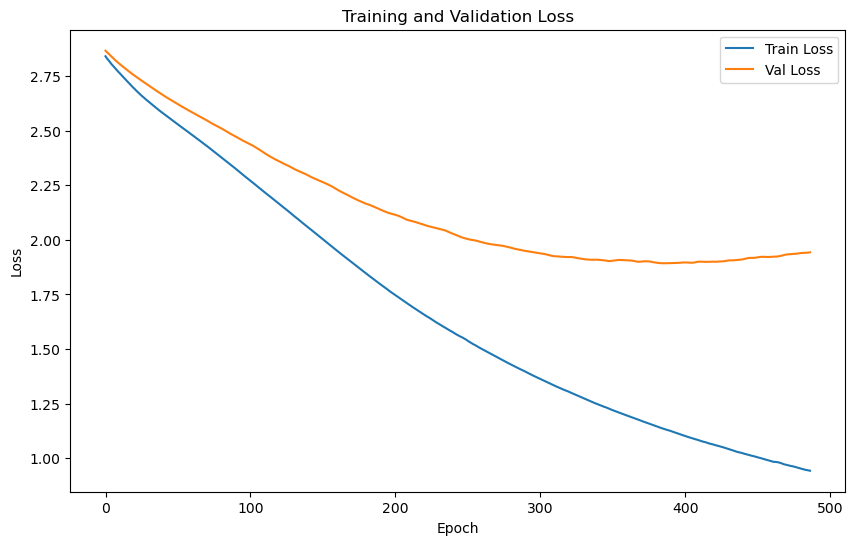

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.9021 | Test Accuracy: 36.62%


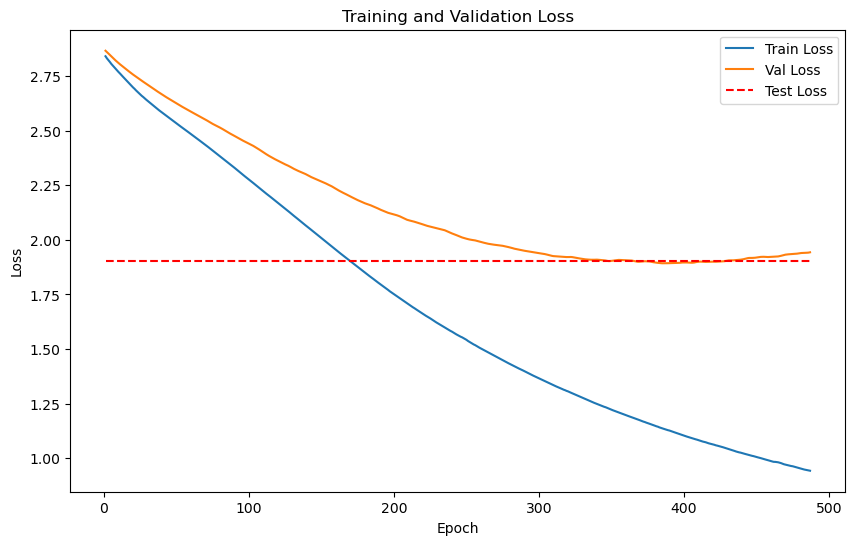

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10089, 64), 
Test labels shape: (10089,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5101
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5350
    Batch [2/2], Val Loss: 0.3005
Epoch [1/2000], Avg Train Loss: 0.5101, Avg Val Loss: 0.4177

Validation loss improved from inf to 0.4177. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5133
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5343
    Batch [2/2], Val Loss: 0.3017
Epoch [2/2000], Avg Train Loss: 0.5133, Avg Val Loss: 0.4180

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.5104
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5335
    Batch [2/2], Val Loss: 0.3029
Epoch [3/2000], Avg Train Loss: 0.5104, Avg Val Loss: 0.4182

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.5129
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5325
    Batch [2/2], Val Loss: 0.3038
Epoch [4/2000], Avg Train Loss: 0.5129, Avg Val Loss: 0.4182

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5014
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5312
    Batch [2/2], Val Loss: 0.3043
Epoch [5/2000], Avg Train Loss: 0.5014, Avg Val Loss: 0.4177

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.5063
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5297
    Batch [2/2], Val Loss: 0.3039
Epoch [6/2000], Avg Train Loss: 0.5063, Avg Val Loss: 0.4168

Validation loss improved from 0.4177 to 0.4168. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.5044
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.3029
Epoch [7/2000], Avg Train Loss: 0.5044, Avg Val Loss: 0.4157

Validation loss improved from 0.4168 to 0.4157. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.5152
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5276
    Batch [2/2], Val Loss: 0.3022
Epoch [8/2000], Avg Train Loss: 0.5152, Avg Val Loss: 0.4149

Validation loss improved from 0.4157 to 0.4149. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5265
    Batch [2/2], Val Loss: 0.3016
Epoch [9/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.4140

Validation loss improved from 0.4149 to 0.4140. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.5042
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5251
    Batch [2/2], Val Loss: 0.3011
Epoch [10/2000], Avg Train Loss: 0.5042, Avg Val Loss: 0.4131

Validation loss improved from 0.4140 to 0.4131. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.5082
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5243
    Batch [2/2], Val Loss: 0.3006
Epoch [11/2000], Avg Train Loss: 0.5082, Avg Val Loss: 0.4124

Validation loss improved from 0.4131 to 0.4124. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.5071
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5239
    Batch [2/2], Val Loss: 0.3005
Epoch [12/2000], Avg Train Loss: 0.5071, Avg Val Loss: 0.4122

Validation loss improved from 0.4124 to 0.4122. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.5029
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5235
    Batch [2/2], Val Loss: 0.3007
Epoch [13/2000], Avg Train Loss: 0.5029, Avg Val Loss: 0.4121

Validation loss improved from 0.4122 to 0.4121. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.5091
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5228
    Batch [2/2], Val Loss: 0.3010
Epoch [14/2000], Avg Train Loss: 0.5091, Avg Val Loss: 0.4119

Validation loss improved from 0.4121 to 0.4119. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4992
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5219
    Batch [2/2], Val Loss: 0.3015
Epoch [15/2000], Avg Train Loss: 0.4992, Avg Val Loss: 0.4117

Validation loss improved from 0.4119 to 0.4117. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.5001
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5211
    Batch [2/2], Val Loss: 0.3020
Epoch [16/2000], Avg Train Loss: 0.5001, Avg Val Loss: 0.4115

Validation loss improved from 0.4117 to 0.4115. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5200
    Batch [2/2], Val Loss: 0.3025
Epoch [17/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.4113

Validation loss improved from 0.4115 to 0.4113. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.5054
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5189
    Batch [2/2], Val Loss: 0.3033
Epoch [18/2000], Avg Train Loss: 0.5054, Avg Val Loss: 0.4111

Validation loss improved from 0.4113 to 0.4111. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.5029
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5179
    Batch [2/2], Val Loss: 0.3042
Epoch [19/2000], Avg Train Loss: 0.5029, Avg Val Loss: 0.4111

Validation loss improved from 0.4111 to 0.4111. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.5028
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.3052
Epoch [20/2000], Avg Train Loss: 0.5028, Avg Val Loss: 0.4111

Validation loss improved from 0.4111 to 0.4111. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.5035
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.3061
Epoch [21/2000], Avg Train Loss: 0.5035, Avg Val Loss: 0.4110

Validation loss improved from 0.4111 to 0.4110. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.5066
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.3071
Epoch [22/2000], Avg Train Loss: 0.5066, Avg Val Loss: 0.4110

Validation loss improved from 0.4110 to 0.4110. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4996
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.3081
Epoch [23/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.4110

Validation loss improved from 0.4110 to 0.4110. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.3090
Epoch [24/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.4110

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5122
    Batch [2/2], Val Loss: 0.3099
Epoch [25/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.4111

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4996
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5114
    Batch [2/2], Val Loss: 0.3108
Epoch [26/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.4111

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.5033
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.3116
Epoch [27/2000], Avg Train Loss: 0.5033, Avg Val Loss: 0.4111

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.5013
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5100
    Batch [2/2], Val Loss: 0.3124
Epoch [28/2000], Avg Train Loss: 0.5013, Avg Val Loss: 0.4112

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4988
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5093
    Batch [2/2], Val Loss: 0.3131
Epoch [29/2000], Avg Train Loss: 0.4988, Avg Val Loss: 0.4112

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.3139
Epoch [30/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.4113

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.5024
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5083
    Batch [2/2], Val Loss: 0.3146
Epoch [31/2000], Avg Train Loss: 0.5024, Avg Val Loss: 0.4114

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.5001
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5078
    Batch [2/2], Val Loss: 0.3152
Epoch [32/2000], Avg Train Loss: 0.5001, Avg Val Loss: 0.4115

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4995
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5075
    Batch [2/2], Val Loss: 0.3158
Epoch [33/2000], Avg Train Loss: 0.4995, Avg Val Loss: 0.4116

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.5026
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5071
    Batch [2/2], Val Loss: 0.3165
Epoch [34/2000], Avg Train Loss: 0.5026, Avg Val Loss: 0.4118

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5067
    Batch [2/2], Val Loss: 0.3170
Epoch [35/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.4119

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5064
    Batch [2/2], Val Loss: 0.3176
Epoch [36/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.4120

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.3181
Epoch [37/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.4121

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5059
    Batch [2/2], Val Loss: 0.3186
Epoch [38/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4122

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5057
    Batch [2/2], Val Loss: 0.3190
Epoch [39/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.4124

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4968
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5054
    Batch [2/2], Val Loss: 0.3195
Epoch [40/2000], Avg Train Loss: 0.4968, Avg Val Loss: 0.4124

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.5022
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5051
    Batch [2/2], Val Loss: 0.3199
Epoch [41/2000], Avg Train Loss: 0.5022, Avg Val Loss: 0.4125

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4989
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.3203
Epoch [42/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.4125

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.3206
Epoch [43/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.4126

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.3209
Epoch [44/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4126

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.3212
Epoch [45/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.4126

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4960
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.3215
Epoch [46/2000], Avg Train Loss: 0.4960, Avg Val Loss: 0.4126

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.3217
Epoch [47/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4126

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.3220
Epoch [48/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.4126

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5030
    Batch [2/2], Val Loss: 0.3223
Epoch [49/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4127

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.3225
Epoch [50/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.4127

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.3228
Epoch [51/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4128

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.3230
Epoch [52/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4128

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.3232
Epoch [53/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4128

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.3234
Epoch [54/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4128

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5022
    Batch [2/2], Val Loss: 0.3235
Epoch [55/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5021
    Batch [2/2], Val Loss: 0.3236
Epoch [56/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5020
    Batch [2/2], Val Loss: 0.3238
Epoch [57/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5019
    Batch [2/2], Val Loss: 0.3239
Epoch [58/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.3240
Epoch [59/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.3241
Epoch [60/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.3242
Epoch [61/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.3242
Epoch [62/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.3243
Epoch [63/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5015
    Batch [2/2], Val Loss: 0.3244
Epoch [64/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5014
    Batch [2/2], Val Loss: 0.3244
Epoch [65/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5014
    Batch [2/2], Val Loss: 0.3245
Epoch [66/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4990
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.3246
Epoch [67/2000], Avg Train Loss: 0.4990, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.3246
Epoch [68/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.3246
Epoch [69/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.3247
Epoch [70/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.5033
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.3247
Epoch [71/2000], Avg Train Loss: 0.5033, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.3247
Epoch [72/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.3248
Epoch [73/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.3248
Epoch [74/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.3248
Epoch [75/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.3248
Epoch [76/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.5010
    Batch [2/2], Val Loss: 0.3249
Epoch [77/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.3249
Epoch [78/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.3249
Epoch [79/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.3249
Epoch [80/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.3249
Epoch [81/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.3250
Epoch [82/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.3250
Epoch [83/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.3250
Epoch [84/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.3250
Epoch [85/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.3250
Epoch [86/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3250
Epoch [87/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3250
Epoch [88/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3250
Epoch [89/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3250
Epoch [90/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3250
Epoch [91/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3250
Epoch [92/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3250
Epoch [93/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3250
Epoch [94/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [95/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [96/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [97/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [98/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [99/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [100/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [101/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [102/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [103/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [104/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [105/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [106/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [107/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [108/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.3251
Epoch [109/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [110/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [111/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [112/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [113/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [114/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [115/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [116/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [117/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [118/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [119/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [120/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [121/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [122/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.3251
Epoch [123/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.4129

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 123!!
No improvement for 100 epochs


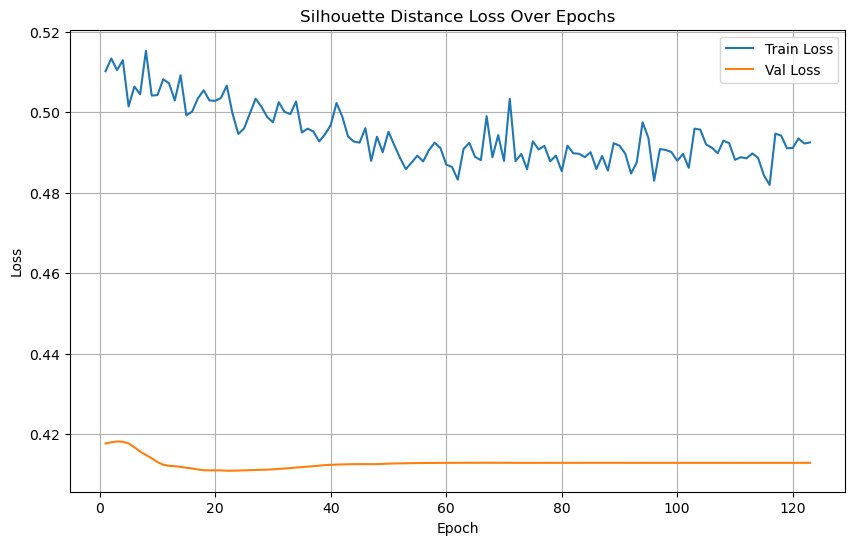

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/158], Loss: 0.4580
Test Batch [20/158], Loss: 0.3782
Test Batch [30/158], Loss: 0.4448


Test Batch [40/158], Loss: 0.3043
Test Batch [50/158], Loss: 0.4327
Test Batch [60/158], Loss: 0.3986


Test Batch [70/158], Loss: 0.1786
Test Batch [80/158], Loss: 0.2248
Test Batch [90/158], Loss: 0.2572
Test Batch [100/158], Loss: 0.2564
Test Batch [110/158], Loss: 0.2586
Test Batch [120/158], Loss: 0.2118


Test Batch [130/158], Loss: 0.5000
Test Batch [140/158], Loss: 0.4117
Test Batch [150/158], Loss: 0.3439



Test Loss: 0.3273


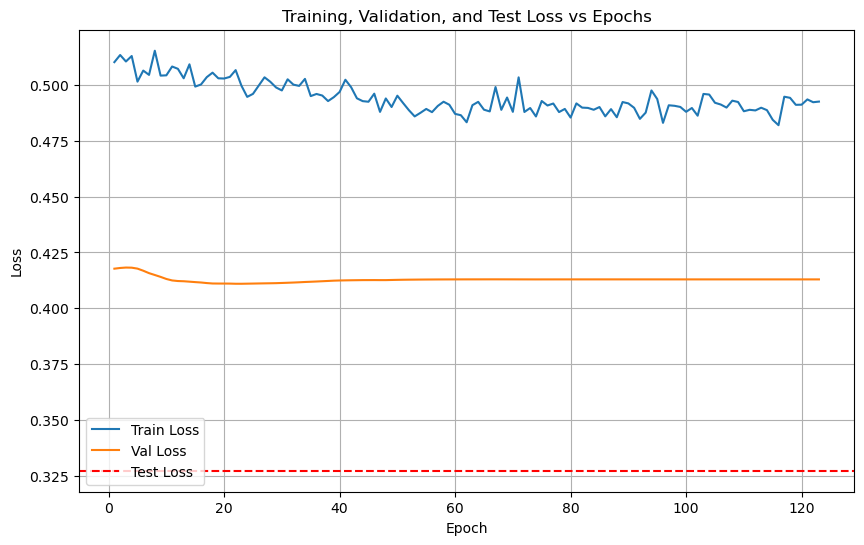

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/158 for test dataset.


  Processed batch 20/158 for test dataset.


  Processed batch 30/158 for test dataset.
  Processed batch 40/158 for test dataset.
  Processed batch 50/158 for test dataset.


  Processed batch 60/158 for test dataset.


  Processed batch 70/158 for test dataset.
  Processed batch 80/158 for test dataset.


  Processed batch 90/158 for test dataset.


  Processed batch 100/158 for test dataset.
  Processed batch 110/158 for test dataset.


  Processed batch 120/158 for test dataset.


  Processed batch 130/158 for test dataset.


  Processed batch 140/158 for test dataset.
  Processed batch 150/158 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 50.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       0.50      0.20      0.29         5
           2       0.25      0.20      0.22         5
           3       0.33      0.20      0.25         5
           4       0.33      0.20      0.25         5
           5       0.38      0.60      0.46         5
           6       0.50      0.60      0.55         5
           7       0.40      0.40      0.40         5
           8       0.62      1.00      0.77         5
           9       0.33      0.60      0.43         5
          10       0.50      0.60      0.55         5
          11       0.00      0.00      0.00         5
          12       1.00      0.80      0.89         5
          13       0.6

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7756  |  Val Loss: 2.7716
Validation loss improved from inf to 2.7716.
[Epoch 2/1000] Train Loss: 2.7699  |  Val Loss: 2.7694
Validation loss improved from 2.7716 to 2.7694.
[Epoch 3/1000] Train Loss: 2.7649  |  Val Loss: 2.7672
Validation loss improved from 2.7694 to 2.7672.
[Epoch 4/1000] Train Loss: 2.7601  |  Val Loss: 2.7651
Validation loss improved from 2.7672 to 2.7651.
[Epoch 5/1000] Train Loss: 2.7560  |  Val Loss: 2.7631
Validation loss improved from 2.7651 to 2.7631.
[Epoch 6/1000] Train Loss: 2.7513  |  Val Loss: 2.7610
Validation loss improved from 2.7631 to 2.7610.
[Epoch 7/1000] Train Loss: 2.7469  |  Val Loss: 2.7590
Validation loss improved from 2.7610 to 2.7590.
[Epoch 8/1000] Train Loss: 2.7430  |  Val Loss: 2.7570
Validation loss improved from 2.7590 to 2.7570.
[Epoch 9/1000] Train Loss: 2.7386  |  Val Loss: 2.7551
Validation loss improved from 2.7570 to 2.7551.
[Epoch 10/1000] Train Loss: 2.7347  |  Val Loss: 2.7531
Validation loss impr

[Epoch 21/1000] Train Loss: 2.6947  |  Val Loss: 2.7333
Validation loss improved from 2.7350 to 2.7333.
[Epoch 22/1000] Train Loss: 2.6915  |  Val Loss: 2.7317
Validation loss improved from 2.7333 to 2.7317.
[Epoch 23/1000] Train Loss: 2.6883  |  Val Loss: 2.7301
Validation loss improved from 2.7317 to 2.7301.
[Epoch 24/1000] Train Loss: 2.6849  |  Val Loss: 2.7286
Validation loss improved from 2.7301 to 2.7286.
[Epoch 25/1000] Train Loss: 2.6817  |  Val Loss: 2.7270
Validation loss improved from 2.7286 to 2.7270.
[Epoch 26/1000] Train Loss: 2.6786  |  Val Loss: 2.7254
Validation loss improved from 2.7270 to 2.7254.
[Epoch 27/1000] Train Loss: 2.6753  |  Val Loss: 2.7238
Validation loss improved from 2.7254 to 2.7238.
[Epoch 28/1000] Train Loss: 2.6718  |  Val Loss: 2.7223
Validation loss improved from 2.7238 to 2.7223.
[Epoch 29/1000] Train Loss: 2.6688  |  Val Loss: 2.7206
Validation loss improved from 2.7223 to 2.7206.
[Epoch 30/1000] Train Loss: 2.6656  |  Val Loss: 2.7191
Validati

[Epoch 40/1000] Train Loss: 2.6329  |  Val Loss: 2.7024
Validation loss improved from 2.7041 to 2.7024.
[Epoch 41/1000] Train Loss: 2.6299  |  Val Loss: 2.7006
Validation loss improved from 2.7024 to 2.7006.
[Epoch 42/1000] Train Loss: 2.6265  |  Val Loss: 2.6989
Validation loss improved from 2.7006 to 2.6989.
[Epoch 43/1000] Train Loss: 2.6233  |  Val Loss: 2.6972
Validation loss improved from 2.6989 to 2.6972.
[Epoch 44/1000] Train Loss: 2.6200  |  Val Loss: 2.6954
Validation loss improved from 2.6972 to 2.6954.
[Epoch 45/1000] Train Loss: 2.6167  |  Val Loss: 2.6936
Validation loss improved from 2.6954 to 2.6936.
[Epoch 46/1000] Train Loss: 2.6136  |  Val Loss: 2.6919
Validation loss improved from 2.6936 to 2.6919.
[Epoch 47/1000] Train Loss: 2.6103  |  Val Loss: 2.6902
Validation loss improved from 2.6919 to 2.6902.
[Epoch 48/1000] Train Loss: 2.6072  |  Val Loss: 2.6885
Validation loss improved from 2.6902 to 2.6885.
[Epoch 49/1000] Train Loss: 2.6040  |  Val Loss: 2.6868
Validati

[Epoch 65/1000] Train Loss: 2.5497  |  Val Loss: 2.6576
Validation loss improved from 2.6595 to 2.6576.
[Epoch 66/1000] Train Loss: 2.5461  |  Val Loss: 2.6557
Validation loss improved from 2.6576 to 2.6557.
[Epoch 67/1000] Train Loss: 2.5425  |  Val Loss: 2.6536
Validation loss improved from 2.6557 to 2.6536.
[Epoch 68/1000] Train Loss: 2.5386  |  Val Loss: 2.6515
Validation loss improved from 2.6536 to 2.6515.
[Epoch 69/1000] Train Loss: 2.5349  |  Val Loss: 2.6494
Validation loss improved from 2.6515 to 2.6494.
[Epoch 70/1000] Train Loss: 2.5311  |  Val Loss: 2.6473
Validation loss improved from 2.6494 to 2.6473.
[Epoch 71/1000] Train Loss: 2.5272  |  Val Loss: 2.6453
Validation loss improved from 2.6473 to 2.6453.
[Epoch 72/1000] Train Loss: 2.5233  |  Val Loss: 2.6432
Validation loss improved from 2.6453 to 2.6432.
[Epoch 73/1000] Train Loss: 2.5191  |  Val Loss: 2.6411
Validation loss improved from 2.6432 to 2.6411.
[Epoch 74/1000] Train Loss: 2.5152  |  Val Loss: 2.6390
Validati

[Epoch 82/1000] Train Loss: 2.4811  |  Val Loss: 2.6202
Validation loss improved from 2.6225 to 2.6202.
[Epoch 83/1000] Train Loss: 2.4769  |  Val Loss: 2.6177
Validation loss improved from 2.6202 to 2.6177.
[Epoch 84/1000] Train Loss: 2.4724  |  Val Loss: 2.6150
Validation loss improved from 2.6177 to 2.6150.
[Epoch 85/1000] Train Loss: 2.4678  |  Val Loss: 2.6125
Validation loss improved from 2.6150 to 2.6125.
[Epoch 86/1000] Train Loss: 2.4630  |  Val Loss: 2.6099
Validation loss improved from 2.6125 to 2.6099.
[Epoch 87/1000] Train Loss: 2.4581  |  Val Loss: 2.6072
Validation loss improved from 2.6099 to 2.6072.
[Epoch 88/1000] Train Loss: 2.4535  |  Val Loss: 2.6045
Validation loss improved from 2.6072 to 2.6045.
[Epoch 89/1000] Train Loss: 2.4489  |  Val Loss: 2.6018
Validation loss improved from 2.6045 to 2.6018.
[Epoch 90/1000] Train Loss: 2.4438  |  Val Loss: 2.5992
Validation loss improved from 2.6018 to 2.5992.
[Epoch 91/1000] Train Loss: 2.4387  |  Val Loss: 2.5966
Validati

[Epoch 109/1000] Train Loss: 2.3434  |  Val Loss: 2.5435
Validation loss improved from 2.5467 to 2.5435.
[Epoch 110/1000] Train Loss: 2.3375  |  Val Loss: 2.5403
Validation loss improved from 2.5435 to 2.5403.
[Epoch 111/1000] Train Loss: 2.3318  |  Val Loss: 2.5371
Validation loss improved from 2.5403 to 2.5371.
[Epoch 112/1000] Train Loss: 2.3259  |  Val Loss: 2.5339
Validation loss improved from 2.5371 to 2.5339.
[Epoch 113/1000] Train Loss: 2.3200  |  Val Loss: 2.5307
Validation loss improved from 2.5339 to 2.5307.
[Epoch 114/1000] Train Loss: 2.3145  |  Val Loss: 2.5274
Validation loss improved from 2.5307 to 2.5274.
[Epoch 115/1000] Train Loss: 2.3085  |  Val Loss: 2.5243
Validation loss improved from 2.5274 to 2.5243.
[Epoch 116/1000] Train Loss: 2.3028  |  Val Loss: 2.5211
Validation loss improved from 2.5243 to 2.5211.
[Epoch 117/1000] Train Loss: 2.2969  |  Val Loss: 2.5181
Validation loss improved from 2.5211 to 2.5181.
[Epoch 118/1000] Train Loss: 2.2910  |  Val Loss: 2.515

[Epoch 122/1000] Train Loss: 2.2676  |  Val Loss: 2.5023
Validation loss improved from 2.5054 to 2.5023.
[Epoch 123/1000] Train Loss: 2.2620  |  Val Loss: 2.4991
Validation loss improved from 2.5023 to 2.4991.
[Epoch 124/1000] Train Loss: 2.2562  |  Val Loss: 2.4958
Validation loss improved from 2.4991 to 2.4958.
[Epoch 125/1000] Train Loss: 2.2503  |  Val Loss: 2.4924
Validation loss improved from 2.4958 to 2.4924.
[Epoch 126/1000] Train Loss: 2.2446  |  Val Loss: 2.4890
Validation loss improved from 2.4924 to 2.4890.
[Epoch 127/1000] Train Loss: 2.2385  |  Val Loss: 2.4856
Validation loss improved from 2.4890 to 2.4856.
[Epoch 128/1000] Train Loss: 2.2327  |  Val Loss: 2.4821
Validation loss improved from 2.4856 to 2.4821.
[Epoch 129/1000] Train Loss: 2.2269  |  Val Loss: 2.4787
Validation loss improved from 2.4821 to 2.4787.
[Epoch 130/1000] Train Loss: 2.2208  |  Val Loss: 2.4753
Validation loss improved from 2.4787 to 2.4753.
[Epoch 131/1000] Train Loss: 2.2148  |  Val Loss: 2.471

[Epoch 144/1000] Train Loss: 2.1378  |  Val Loss: 2.4282
Validation loss improved from 2.4313 to 2.4282.
[Epoch 145/1000] Train Loss: 2.1319  |  Val Loss: 2.4250
Validation loss improved from 2.4282 to 2.4250.
[Epoch 146/1000] Train Loss: 2.1260  |  Val Loss: 2.4218
Validation loss improved from 2.4250 to 2.4218.
[Epoch 147/1000] Train Loss: 2.1202  |  Val Loss: 2.4187
Validation loss improved from 2.4218 to 2.4187.
[Epoch 148/1000] Train Loss: 2.1139  |  Val Loss: 2.4156
Validation loss improved from 2.4187 to 2.4156.
[Epoch 149/1000] Train Loss: 2.1083  |  Val Loss: 2.4124
Validation loss improved from 2.4156 to 2.4124.
[Epoch 150/1000] Train Loss: 2.1022  |  Val Loss: 2.4089
Validation loss improved from 2.4124 to 2.4089.
[Epoch 151/1000] Train Loss: 2.0964  |  Val Loss: 2.4055
Validation loss improved from 2.4089 to 2.4055.
[Epoch 152/1000] Train Loss: 2.0903  |  Val Loss: 2.4021
Validation loss improved from 2.4055 to 2.4021.
[Epoch 153/1000] Train Loss: 2.0844  |  Val Loss: 2.398

[Epoch 161/1000] Train Loss: 2.0357  |  Val Loss: 2.3736
Validation loss improved from 2.3769 to 2.3736.
[Epoch 162/1000] Train Loss: 2.0296  |  Val Loss: 2.3703
Validation loss improved from 2.3736 to 2.3703.
[Epoch 163/1000] Train Loss: 2.0235  |  Val Loss: 2.3668
Validation loss improved from 2.3703 to 2.3668.
[Epoch 164/1000] Train Loss: 2.0178  |  Val Loss: 2.3633
Validation loss improved from 2.3668 to 2.3633.
[Epoch 165/1000] Train Loss: 2.0115  |  Val Loss: 2.3598
Validation loss improved from 2.3633 to 2.3598.
[Epoch 166/1000] Train Loss: 2.0057  |  Val Loss: 2.3563
Validation loss improved from 2.3598 to 2.3563.
[Epoch 167/1000] Train Loss: 1.9996  |  Val Loss: 2.3528
Validation loss improved from 2.3563 to 2.3528.
[Epoch 168/1000] Train Loss: 1.9939  |  Val Loss: 2.3493
Validation loss improved from 2.3528 to 2.3493.
[Epoch 169/1000] Train Loss: 1.9880  |  Val Loss: 2.3459
Validation loss improved from 2.3493 to 2.3459.
[Epoch 170/1000] Train Loss: 1.9821  |  Val Loss: 2.342

[Epoch 184/1000] Train Loss: 1.9011  |  Val Loss: 2.3009
Validation loss improved from 2.3036 to 2.3009.
[Epoch 185/1000] Train Loss: 1.8953  |  Val Loss: 2.2981
Validation loss improved from 2.3009 to 2.2981.
[Epoch 186/1000] Train Loss: 1.8893  |  Val Loss: 2.2955
Validation loss improved from 2.2981 to 2.2955.
[Epoch 187/1000] Train Loss: 1.8834  |  Val Loss: 2.2928
Validation loss improved from 2.2955 to 2.2928.
[Epoch 188/1000] Train Loss: 1.8776  |  Val Loss: 2.2900
Validation loss improved from 2.2928 to 2.2900.
[Epoch 189/1000] Train Loss: 1.8714  |  Val Loss: 2.2870
Validation loss improved from 2.2900 to 2.2870.
[Epoch 190/1000] Train Loss: 1.8658  |  Val Loss: 2.2838
Validation loss improved from 2.2870 to 2.2838.
[Epoch 191/1000] Train Loss: 1.8597  |  Val Loss: 2.2807
Validation loss improved from 2.2838 to 2.2807.
[Epoch 192/1000] Train Loss: 1.8537  |  Val Loss: 2.2775
Validation loss improved from 2.2807 to 2.2775.
[Epoch 193/1000] Train Loss: 1.8478  |  Val Loss: 2.274

[Epoch 199/1000] Train Loss: 1.8122  |  Val Loss: 2.2568
Validation loss improved from 2.2595 to 2.2568.
[Epoch 200/1000] Train Loss: 1.8063  |  Val Loss: 2.2540
Validation loss improved from 2.2568 to 2.2540.
[Epoch 201/1000] Train Loss: 1.8003  |  Val Loss: 2.2513
Validation loss improved from 2.2540 to 2.2513.
[Epoch 202/1000] Train Loss: 1.7945  |  Val Loss: 2.2487
Validation loss improved from 2.2513 to 2.2487.
[Epoch 203/1000] Train Loss: 1.7888  |  Val Loss: 2.2459
Validation loss improved from 2.2487 to 2.2459.
[Epoch 204/1000] Train Loss: 1.7830  |  Val Loss: 2.2431
Validation loss improved from 2.2459 to 2.2431.
[Epoch 205/1000] Train Loss: 1.7773  |  Val Loss: 2.2402
Validation loss improved from 2.2431 to 2.2402.
[Epoch 206/1000] Train Loss: 1.7718  |  Val Loss: 2.2373
Validation loss improved from 2.2402 to 2.2373.
[Epoch 207/1000] Train Loss: 1.7663  |  Val Loss: 2.2345
Validation loss improved from 2.2373 to 2.2345.
[Epoch 208/1000] Train Loss: 1.7607  |  Val Loss: 2.231

[Epoch 226/1000] Train Loss: 1.6572  |  Val Loss: 2.1853
Validation loss improved from 2.1876 to 2.1853.
[Epoch 227/1000] Train Loss: 1.6514  |  Val Loss: 2.1828
Validation loss improved from 2.1853 to 2.1828.
[Epoch 228/1000] Train Loss: 1.6456  |  Val Loss: 2.1802
Validation loss improved from 2.1828 to 2.1802.
[Epoch 229/1000] Train Loss: 1.6399  |  Val Loss: 2.1778
Validation loss improved from 2.1802 to 2.1778.
[Epoch 230/1000] Train Loss: 1.6343  |  Val Loss: 2.1755
Validation loss improved from 2.1778 to 2.1755.
[Epoch 231/1000] Train Loss: 1.6288  |  Val Loss: 2.1733
Validation loss improved from 2.1755 to 2.1733.
[Epoch 232/1000] Train Loss: 1.6232  |  Val Loss: 2.1712
Validation loss improved from 2.1733 to 2.1712.
[Epoch 233/1000] Train Loss: 1.6176  |  Val Loss: 2.1693
Validation loss improved from 2.1712 to 2.1693.
[Epoch 234/1000] Train Loss: 1.6121  |  Val Loss: 2.1672
Validation loss improved from 2.1693 to 2.1672.
[Epoch 235/1000] Train Loss: 1.6064  |  Val Loss: 2.164

[Epoch 239/1000] Train Loss: 1.5842  |  Val Loss: 2.1547
Validation loss improved from 2.1574 to 2.1547.
[Epoch 240/1000] Train Loss: 1.5789  |  Val Loss: 2.1520
Validation loss improved from 2.1547 to 2.1520.
[Epoch 241/1000] Train Loss: 1.5734  |  Val Loss: 2.1495
Validation loss improved from 2.1520 to 2.1495.
[Epoch 242/1000] Train Loss: 1.5679  |  Val Loss: 2.1472
Validation loss improved from 2.1495 to 2.1472.
[Epoch 243/1000] Train Loss: 1.5626  |  Val Loss: 2.1447
Validation loss improved from 2.1472 to 2.1447.
[Epoch 244/1000] Train Loss: 1.5571  |  Val Loss: 2.1424
Validation loss improved from 2.1447 to 2.1424.
[Epoch 245/1000] Train Loss: 1.5518  |  Val Loss: 2.1400
Validation loss improved from 2.1424 to 2.1400.
[Epoch 246/1000] Train Loss: 1.5464  |  Val Loss: 2.1379
Validation loss improved from 2.1400 to 2.1379.
[Epoch 247/1000] Train Loss: 1.5412  |  Val Loss: 2.1358
Validation loss improved from 2.1379 to 2.1358.
[Epoch 248/1000] Train Loss: 1.5357  |  Val Loss: 2.133

[Epoch 266/1000] Train Loss: 1.4429  |  Val Loss: 2.1061
Validation loss improved from 2.1080 to 2.1061.
[Epoch 267/1000] Train Loss: 1.4379  |  Val Loss: 2.1042
Validation loss improved from 2.1061 to 2.1042.
[Epoch 268/1000] Train Loss: 1.4329  |  Val Loss: 2.1020
Validation loss improved from 2.1042 to 2.1020.
[Epoch 269/1000] Train Loss: 1.4281  |  Val Loss: 2.1000
Validation loss improved from 2.1020 to 2.1000.
[Epoch 270/1000] Train Loss: 1.4227  |  Val Loss: 2.0983
Validation loss improved from 2.1000 to 2.0983.
[Epoch 271/1000] Train Loss: 1.4177  |  Val Loss: 2.0966
Validation loss improved from 2.0983 to 2.0966.
[Epoch 272/1000] Train Loss: 1.4124  |  Val Loss: 2.0952
Validation loss improved from 2.0966 to 2.0952.
[Epoch 273/1000] Train Loss: 1.4076  |  Val Loss: 2.0938
Validation loss improved from 2.0952 to 2.0938.
[Epoch 274/1000] Train Loss: 1.4026  |  Val Loss: 2.0923
Validation loss improved from 2.0938 to 2.0923.
[Epoch 275/1000] Train Loss: 1.3976  |  Val Loss: 2.090

[Epoch 282/1000] Train Loss: 1.3620  |  Val Loss: 2.0786
Validation loss improved from 2.0802 to 2.0786.
[Epoch 283/1000] Train Loss: 1.3571  |  Val Loss: 2.0771
Validation loss improved from 2.0786 to 2.0771.
[Epoch 284/1000] Train Loss: 1.3522  |  Val Loss: 2.0756
Validation loss improved from 2.0771 to 2.0756.
[Epoch 285/1000] Train Loss: 1.3475  |  Val Loss: 2.0740
Validation loss improved from 2.0756 to 2.0740.
[Epoch 286/1000] Train Loss: 1.3429  |  Val Loss: 2.0726
Validation loss improved from 2.0740 to 2.0726.
[Epoch 287/1000] Train Loss: 1.3382  |  Val Loss: 2.0709
Validation loss improved from 2.0726 to 2.0709.
[Epoch 288/1000] Train Loss: 1.3341  |  Val Loss: 2.0694
Validation loss improved from 2.0709 to 2.0694.
[Epoch 289/1000] Train Loss: 1.3293  |  Val Loss: 2.0683
Validation loss improved from 2.0694 to 2.0683.
[Epoch 290/1000] Train Loss: 1.3245  |  Val Loss: 2.0674
Validation loss improved from 2.0683 to 2.0674.
[Epoch 291/1000] Train Loss: 1.3194  |  Val Loss: 2.066

[Epoch 304/1000] Train Loss: 1.2585  |  Val Loss: 2.0564
Validation loss improved from 2.0574 to 2.0564.
[Epoch 305/1000] Train Loss: 1.2538  |  Val Loss: 2.0554
Validation loss improved from 2.0564 to 2.0554.
[Epoch 306/1000] Train Loss: 1.2494  |  Val Loss: 2.0542
Validation loss improved from 2.0554 to 2.0542.
[Epoch 307/1000] Train Loss: 1.2446  |  Val Loss: 2.0530
Validation loss improved from 2.0542 to 2.0530.
[Epoch 308/1000] Train Loss: 1.2404  |  Val Loss: 2.0523
Validation loss improved from 2.0530 to 2.0523.
[Epoch 309/1000] Train Loss: 1.2357  |  Val Loss: 2.0518
Validation loss improved from 2.0523 to 2.0518.
[Epoch 310/1000] Train Loss: 1.2313  |  Val Loss: 2.0511
Validation loss improved from 2.0518 to 2.0511.
[Epoch 311/1000] Train Loss: 1.2267  |  Val Loss: 2.0505
Validation loss improved from 2.0511 to 2.0505.
[Epoch 312/1000] Train Loss: 1.2221  |  Val Loss: 2.0500
Validation loss improved from 2.0505 to 2.0500.
[Epoch 313/1000] Train Loss: 1.2175  |  Val Loss: 2.049

[Epoch 319/1000] Train Loss: 1.1906  |  Val Loss: 2.0441
Validation loss improved from 2.0453 to 2.0441.
[Epoch 320/1000] Train Loss: 1.1861  |  Val Loss: 2.0428
Validation loss improved from 2.0441 to 2.0428.
[Epoch 321/1000] Train Loss: 1.1816  |  Val Loss: 2.0413
Validation loss improved from 2.0428 to 2.0413.
[Epoch 322/1000] Train Loss: 1.1773  |  Val Loss: 2.0402
Validation loss improved from 2.0413 to 2.0402.
[Epoch 323/1000] Train Loss: 1.1729  |  Val Loss: 2.0395
Validation loss improved from 2.0402 to 2.0395.
[Epoch 324/1000] Train Loss: 1.1686  |  Val Loss: 2.0387
Validation loss improved from 2.0395 to 2.0387.
[Epoch 325/1000] Train Loss: 1.1643  |  Val Loss: 2.0377
Validation loss improved from 2.0387 to 2.0377.
[Epoch 326/1000] Train Loss: 1.1598  |  Val Loss: 2.0365
Validation loss improved from 2.0377 to 2.0365.
[Epoch 327/1000] Train Loss: 1.1557  |  Val Loss: 2.0356
Validation loss improved from 2.0365 to 2.0356.
[Epoch 328/1000] Train Loss: 1.1513  |  Val Loss: 2.034

[Epoch 345/1000] Train Loss: 1.0806  |  Val Loss: 2.0247
Validation loss improved from 2.0255 to 2.0247.
[Epoch 346/1000] Train Loss: 1.0767  |  Val Loss: 2.0239
Validation loss improved from 2.0247 to 2.0239.
[Epoch 347/1000] Train Loss: 1.0727  |  Val Loss: 2.0237
Validation loss improved from 2.0239 to 2.0237.
[Epoch 348/1000] Train Loss: 1.0686  |  Val Loss: 2.0243
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 349/1000] Train Loss: 1.0649  |  Val Loss: 2.0251
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 350/1000] Train Loss: 1.0612  |  Val Loss: 2.0257
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 351/1000] Train Loss: 1.0575  |  Val Loss: 2.0262
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 352/1000] Train Loss: 1.0536  |  Val Loss: 2.0271
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 353/1000] Train Loss: 1.0497  |  Val Loss: 2.0278
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 354/1000] Tr

[Epoch 356/1000] Train Loss: 1.0378  |  Val Loss: 2.0272
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 357/1000] Train Loss: 1.0340  |  Val Loss: 2.0271
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 358/1000] Train Loss: 1.0302  |  Val Loss: 2.0273
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 359/1000] Train Loss: 1.0262  |  Val Loss: 2.0274
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 360/1000] Train Loss: 1.0225  |  Val Loss: 2.0272
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 361/1000] Train Loss: 1.0186  |  Val Loss: 2.0271
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 362/1000] Train Loss: 1.0150  |  Val Loss: 2.0272
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 363/1000] Train Loss: 1.0111  |  Val Loss: 2.0272
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 364/1000] Train Loss: 1.0074  |  Val Loss: 2.0278
!! Validation loss did NOT improve !! Patience: 

[Epoch 386/1000] Train Loss: 0.9306  |  Val Loss: 2.0261
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 387/1000] Train Loss: 0.9272  |  Val Loss: 2.0273
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 388/1000] Train Loss: 0.9239  |  Val Loss: 2.0285
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 389/1000] Train Loss: 0.9207  |  Val Loss: 2.0293
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 390/1000] Train Loss: 0.9177  |  Val Loss: 2.0293
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 391/1000] Train Loss: 0.9145  |  Val Loss: 2.0285
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 392/1000] Train Loss: 0.9111  |  Val Loss: 2.0272
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 393/1000] Train Loss: 0.9078  |  Val Loss: 2.0267
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 394/1000] Train Loss: 0.9047  |  Val Loss: 2.0267
!! Validation loss did NOT improve !! Patience:

[Epoch 396/1000] Train Loss: 0.8984  |  Val Loss: 2.0271
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 397/1000] Train Loss: 0.8952  |  Val Loss: 2.0276
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 398/1000] Train Loss: 0.8922  |  Val Loss: 2.0282
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 399/1000] Train Loss: 0.8888  |  Val Loss: 2.0288
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 400/1000] Train Loss: 0.8857  |  Val Loss: 2.0295
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 401/1000] Train Loss: 0.8828  |  Val Loss: 2.0299
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 402/1000] Train Loss: 0.8797  |  Val Loss: 2.0300
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 403/1000] Train Loss: 0.8767  |  Val Loss: 2.0301
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 404/1000] Train Loss: 0.8735  |  Val Loss: 2.0299
!! Validation loss did NOT improve !! Patience:

[Epoch 425/1000] Train Loss: 0.8139  |  Val Loss: 2.0372
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 426/1000] Train Loss: 0.8113  |  Val Loss: 2.0385
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 427/1000] Train Loss: 0.8086  |  Val Loss: 2.0394
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 428/1000] Train Loss: 0.8060  |  Val Loss: 2.0406
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 429/1000] Train Loss: 0.8036  |  Val Loss: 2.0418
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 430/1000] Train Loss: 0.8010  |  Val Loss: 2.0428
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 431/1000] Train Loss: 0.7984  |  Val Loss: 2.0436
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 432/1000] Train Loss: 0.7961  |  Val Loss: 2.0448
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 433/1000] Train Loss: 0.7936  |  Val Loss: 2.0462
!! Validation loss did NOT improve !! Patience:

[Epoch 438/1000] Train Loss: 0.7802  |  Val Loss: 2.0470
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 439/1000] Train Loss: 0.7777  |  Val Loss: 2.0466
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 440/1000] Train Loss: 0.7751  |  Val Loss: 2.0468
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 441/1000] Train Loss: 0.7728  |  Val Loss: 2.0476
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 442/1000] Train Loss: 0.7705  |  Val Loss: 2.0490
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 443/1000] Train Loss: 0.7675  |  Val Loss: 2.0507
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 444/1000] Train Loss: 0.7653  |  Val Loss: 2.0526
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 445/1000] Train Loss: 0.7630  |  Val Loss: 2.0547
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 446/1000] Train Loss: 0.7607  |  Val Loss: 2.0568
!! Validation loss did NOT improve !! Patience:

[Epoch 470/1000] Train Loss: 0.7065  |  Val Loss: 2.0920
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 471/1000] Train Loss: 0.7042  |  Val Loss: 2.0928
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 472/1000] Train Loss: 0.7019  |  Val Loss: 2.0932
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 473/1000] Train Loss: 0.6998  |  Val Loss: 2.0928
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 474/1000] Train Loss: 0.6980  |  Val Loss: 2.0928
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 475/1000] Train Loss: 0.6956  |  Val Loss: 2.0933
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 475 !!
No improvement for 100 epochs.


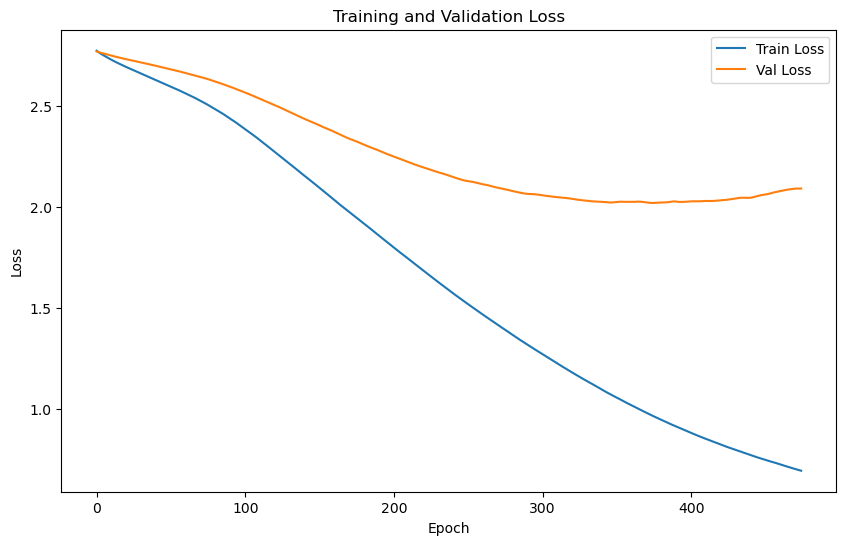

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.9817 | Test Accuracy: 40.20%


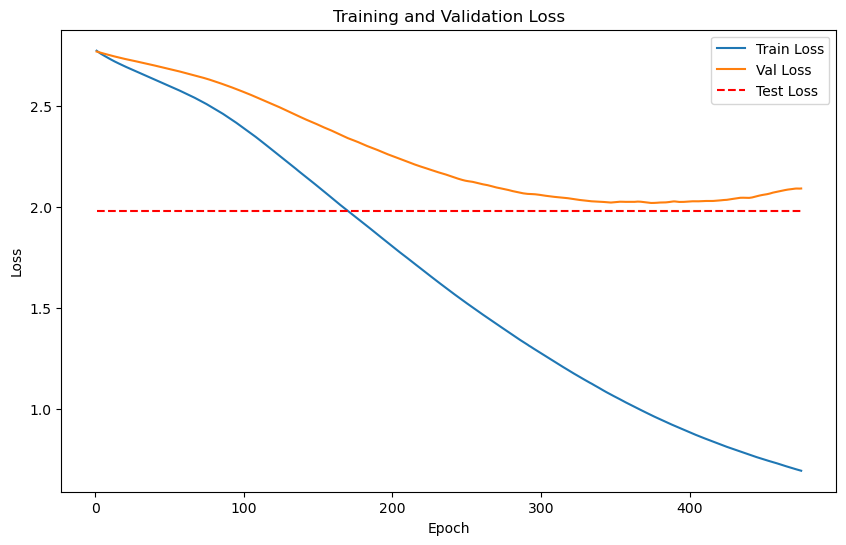

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


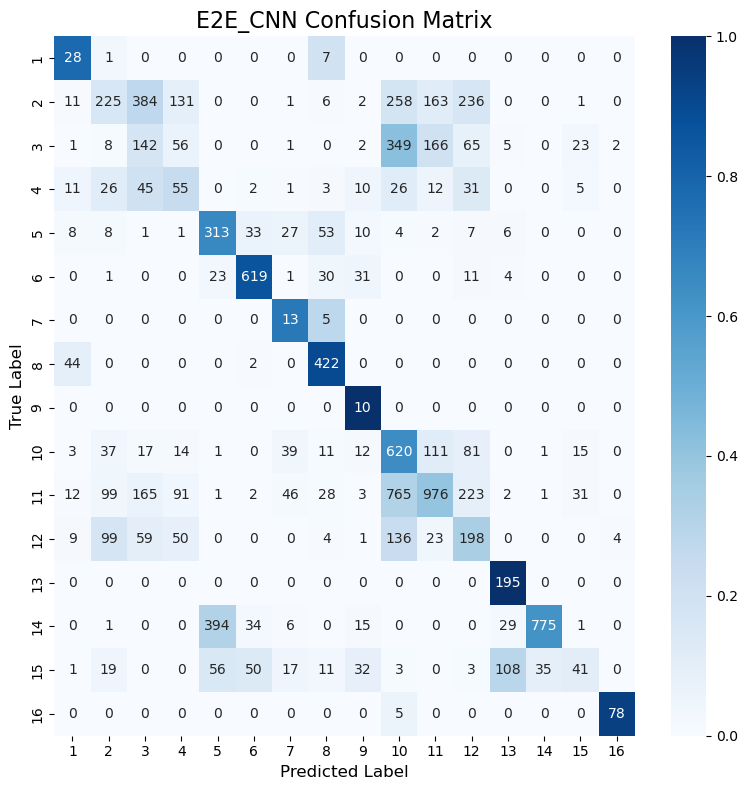

Classification Accuracy: 46.68%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


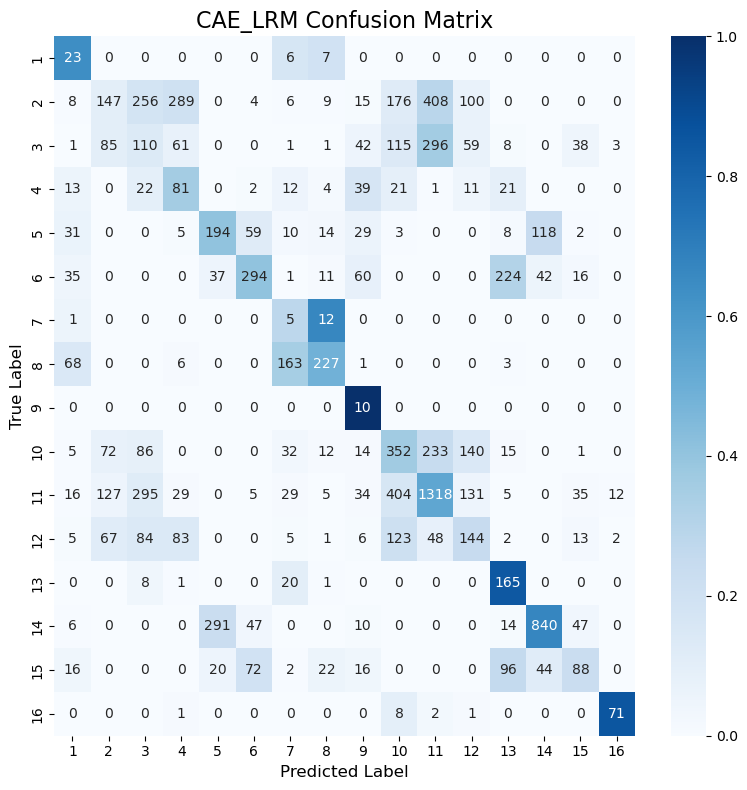

Classification Accuracy: 40.33%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


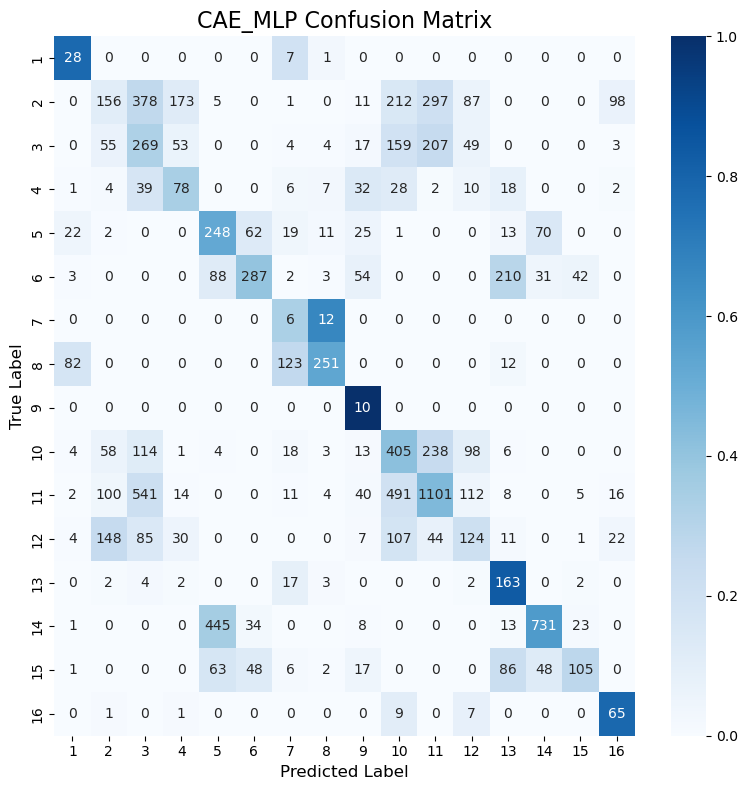

Classification Accuracy: 39.91%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


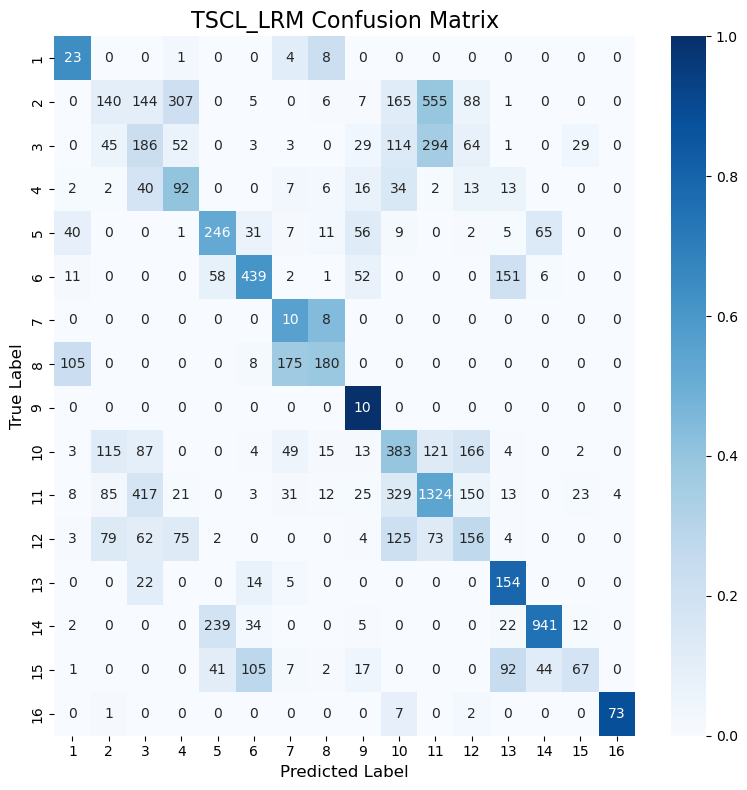

Classification Accuracy: 43.85%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


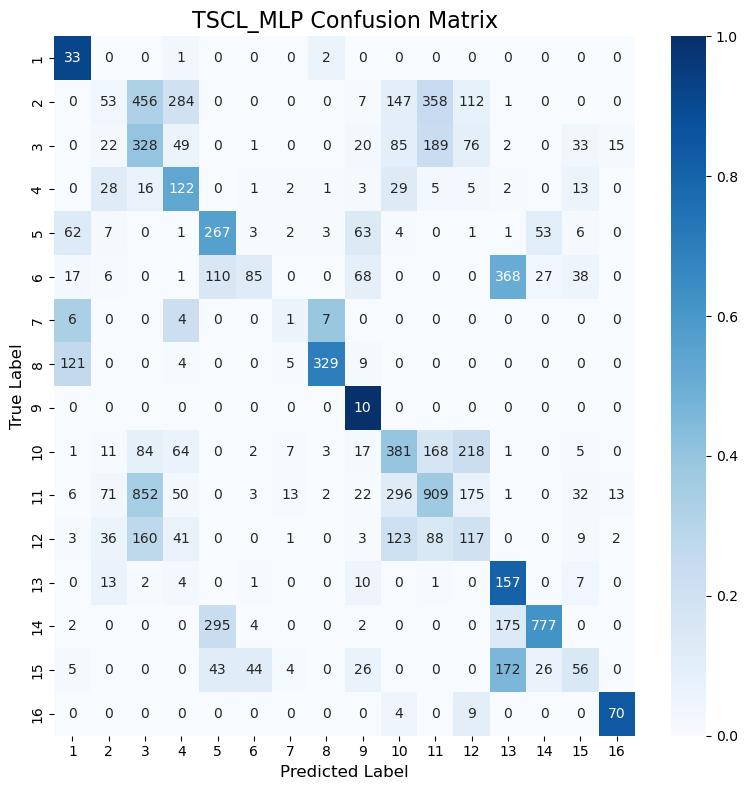

Classification Accuracy: 36.62%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


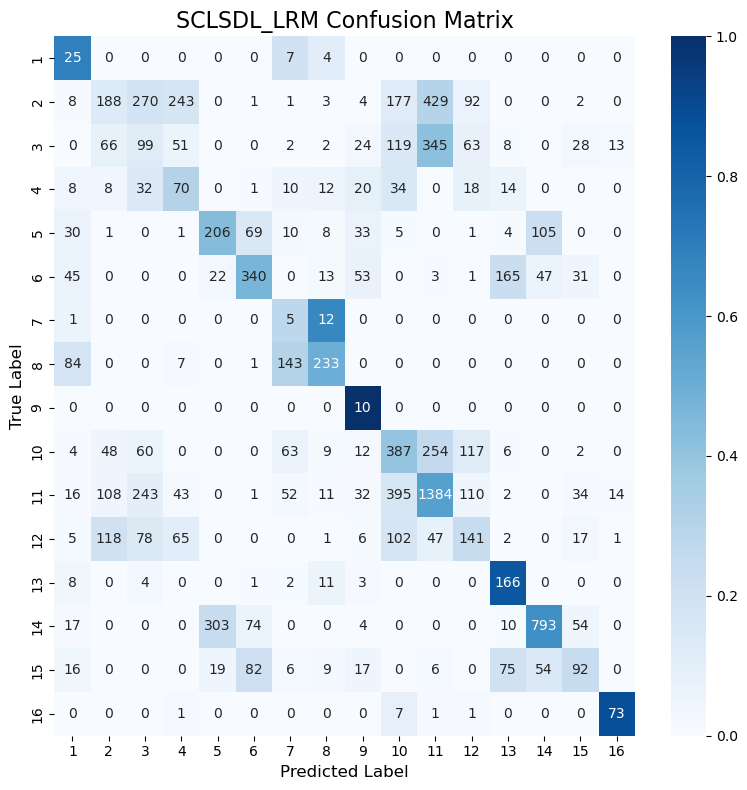

Classification Accuracy: 41.75%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


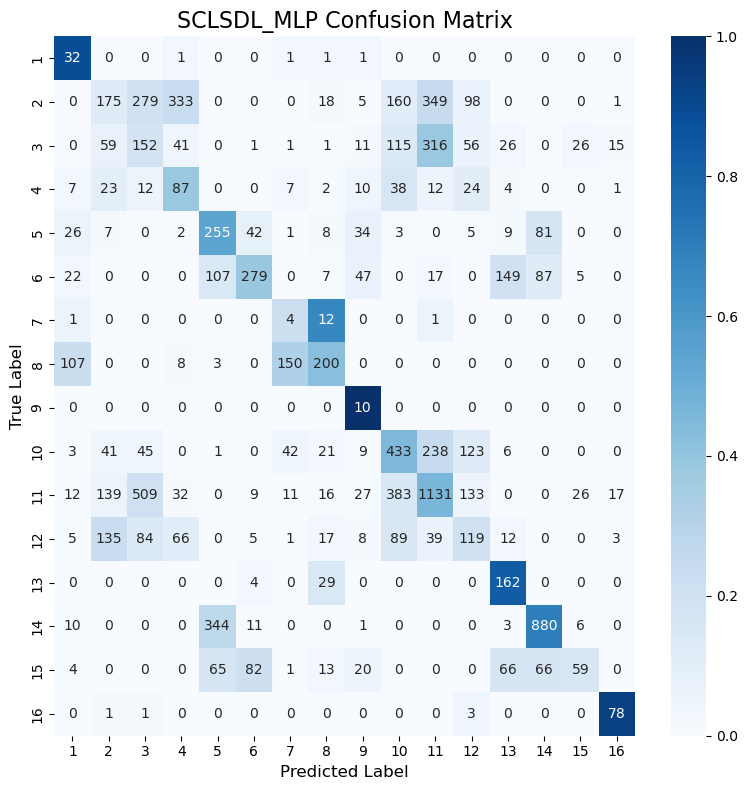

Classification Accuracy: 40.20%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          46.68
1    LRM (CAE)          40.33
2    MLP (CAE)          39.91
3     TSCL LRM          43.85
4     TSCL MLP          36.62
5  SCL_SDL LRM          41.75
6  SCL_SDL MLP          40.20

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          46.68
3     TSCL LRM          43.85
5  SCL_SDL LRM          41.75
1    LRM (CAE)          40.33
6  SCL_SDL MLP          40.20
2    MLP (CAE)          39.91
4     TSCL MLP          36.62
